<h1 align="center">Performance Robustness Evaluation for Statistical Classifiers </h1> 

# Issue #2 - Startup task: Train & test a classification model (by Alberginia)

The goal of this contribution is to be a proof of concept on how analysis tools, which can be used across a wide range of different problems and datasets, can be developed. Hence, the modules have been conceived so they are data agnostic and can be reused and generalised.

A number of **analyses have been carried out on all 5 datasets**, and a similar linear Support Vector Classifier model has been used for classification of all samples. The only differences have been the variable rescaling, and the use of weights during the model training, to compensate data imbalances, which have been carried out only in the datasets that needed it. And although model performance has been measured, there has been no model selection at this stage.

I have structured my code using a .py file which contains all the modules ("data_exploration.py"). This .py file can also be executed in the terminal with **python3 data_exploration.py ../../datasets/generated.csv** or a similar instruction, so that all functions run sequentially and their functionality can be seen in a single command.

In [67]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

from data_exploration import *

In [24]:
dataset_names = ("generated", "vehicles", "eeg", "winequality", "defaults")
dataset_files = ["../../datasets/" + dataset_names[x] + ".csv" for x in range(len(dataset_names))]

# generated.csv
This is a well-behaved dataset that has been automatically generated to test and practice on.

In [25]:
dataset, dataset_name = load_file(dataset_files[0])

# 1. Exploratory analysis of the datasets

## Basic descriptors (generated.csv)

The idea with the following function is to gather a series of straight forward details from the datasets to get a first impression.   

In particular:
* The volume of data entries.
* How many variables it has and their names.
* **How many classes there are and their names** -> Depending on how many classes we would be able to choose a binary classification model or we will have to use a multiclass model.
* Find out **how many data entries correspond to each class**. -> If **the dataset is imbalanced** and one class is much more populated than another, this afects the training, so it **needs to be compensated**. It could appear that we have an accurate prediction while in reality it's simply always guessing the dominant class. Most research assumes that there is imbalance when there is a minority class of 10-20%.

  There is a "weight_advisor" function and if two classes have a population ratio larger than 1.1 the code displays this ratio and if the assymmetry reaches  a class 4 times more populated it displays a warning. There are many ways to account for that difference, in this case, we'll use a **weighting method** during the optimization of the model, so that input data from less frequent classes has a larger contribution in the outcome.
     
  
* A few data entry samples.
* A summary of statistical descriptors for each variable (average, maximum and minimum value, etc).




In [17]:
table_descriptors(dataset)


Dataset shape:  (20000, 5)

There are 5 columns: 
['0', '1', '2', '3', 'label']

This dataset has 3 classes: 
[0, 1, 2]
Each class has [6667, 6667, 6666] elements, respectively.

Dataset head:  <bound method NDFrame.head of               0         1         2         3  label
0     -0.525336  3.623456  1.680293  2.075983      0
1      9.534497 -8.348758  0.112068  6.815969      1
2      8.524880 -7.082612 -0.868522  5.211075      1
3      6.826851 -8.784989  0.090649  4.446359      1
4     -2.591003  5.138362  1.059329  1.319494      0
...         ...       ...       ...       ...    ...
19995  6.590158 -8.562936  0.964792  5.984862      1
19996  8.715324 -7.847383 -0.415671  6.783874      1
19997  6.547144 -8.264512 -1.492629  5.186666      1
19998 -0.781900  4.160036  5.067404  8.881871      2
19999  0.296122  3.978478  1.358180  1.495554      0

[20000 rows x 5 columns]>

Dataset descriptive statistics: 
                   0             1             2             3         label
c

### Conclusions in the case of the "generated.csv" dataset:
* We have a good volume of data.
* There are 3 classes, so we will have to use a model that allows **multiclass** classifications.
* There is **NO imbalance** at all.

## Variable scaling (generated.csv)

Having a **large difference in the scale of the variables is also a problem** because most of optimization trainings are based in **distance measurements**, so if some variables have much larger variations than others they will have a much larger impact in the optimization, regardless on whether those variables have good predictive properties or not.
  
The goal of the following function is to find out visually with just one glance if this can pose a problem or not. It plots the value ranges of all variables side by side, to  have a certain control on that issue and quickly assess the scaling.

This problem can be solved by rescaling all variables to an equal interval. Normally, either (-1,1) or (0,1) are used.

         min        max   interval
0  -4.400123  11.044036  15.444159
1 -11.219695   7.411504  18.631199
2  -4.276724   6.789665  11.066388
3  -2.116425  13.484701  15.601126


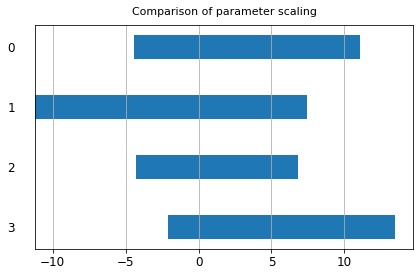

In [18]:
scaling_plot(dataset.iloc[:,:-1], dataset_name)

### Conclusions in the case of the "generated.csv" dataset:
* The scaling among the different variables (0, 1, 2, 3) is reasonably similar, although no identical.
* It can be rescaled to improve it, but it wouldn't affect that much if we didn't.

## Stacked variable histograms (generated.csv)

To know how often each variable takes certain values provides a lot of information on the sample, therefore I've added several functions below that yield an histogram with the frequencies of the variables:
* histograms(dataset, stacked_classes, grid=3, bins=11)
* histograms_specific(dataset, stacked_classes, list_of_variables, grid = 3, bins=11)
* histograms_all(dataset, stacked_classes, grid=3, bins=11)

They can be used to see a preview of the projections for the first variables, to examine particular variables, or to show the histograms of all the variables, respectively. The functions are explained in more detal in their docstrings.

I also introduced a **color mapping that yields different coloring for the frequencies of each class**. The goal was to have a very clear idea at first sight if each class has a tendency or not to take certain values more than another class, or if it's all mixed. **Classes that take very different values for certain variables than other classes are easier to predict**.
 
The second argument  of the function indicates if the classes should be stacked or overlapping in the histogram (True = stacked, False = overlapping). These histograms provide different information, so its useful to have both kinds. In the case of a stacked histogram the area occupied by each color is equivalent to the data volume, so it's good to grasp visually how the absolute amounts of frequencies of each class compare. They also have the advantage that there's no hidden information, such as it often happens with the overlapping projections. 

Stacked histograms are also good to visualise the contribution of each class to the total frequencies. If we disregard the class separation and don't take notice of the different colors, the global profile accounts for all data entries.

If the total number of bins of each histogram is set to a lower value the calculation is quicker and a qualitative overview is available without too much time, but they can be increased to obtain nicer graphs.


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



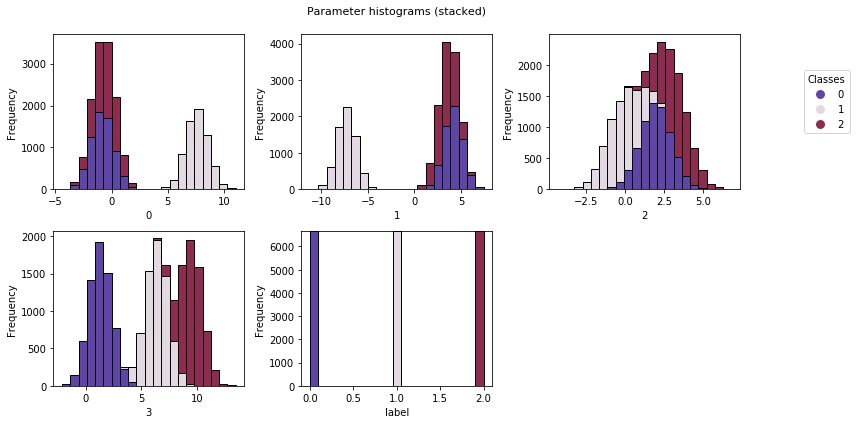

In [6]:
histograms_all(dataset, dataset_name, True, grid=3, bins=21)

### Conclusions in the case of the "generated.csv" dataset:
* You can tell that this dataset is generated data because it's very well behaved. 

* We can also observe that **the dataset is balanced** and that there are equal amounts of each class (although we already knew due to the outcome of the first function).

* It is also clear that **"class 1" will be easy to predict** because it yields very distinct values both of the variable "0" and of the variable "1".

## Overlapping variable histograms (generated.csv)

Overlapping histograms allow to compare the **shape of the distributions of each class**. Whether they have the same height, width, multiple peaks, etc. However, in datasets with many overlapping classes and messy distributions this plot is not very useful. The coloring is somewhat transparent so that the shapes of the distributions are clearer and can be compared. 

Like in the previous figure, the number of bins in these histograms can also be easily increased. Here is particularly interesting to have a higher binning to have a better shape and be able to compare details among the class distributions. 

However, the binning is limited by the volume of the sample, samples without many data points need to have a lower number of bins to accummulate a minimum amount of points, in order to keep being informative.


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



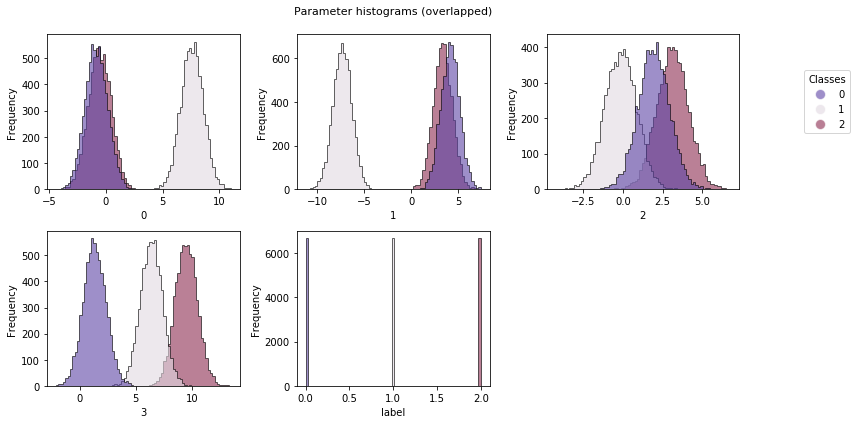

In [7]:
histograms_all(dataset, dataset_name, False, grid=3, bins=75)

### Conclusions in the case of the "generated.csv" dataset:
* Again is made obvious that this is a generated dataset. Each class has a nice peak shape. 
* It is also clear that the distribution parameters of the three classes are the same (height, width, etc).

## 2D projections of the variable space (generated.csv)

Although most datasets have normally too many variables to be fully represented in paper or the computer, the partial information of 2D projections provides a great deal of information to help understand them. Specially when we don't focus in a single one, but look instead at a large collection of them depicting many different combinations of parameters.

2D projections also allow to see **correlations between the variables**. Obviously, all of them are perfectly correlated with themselves and the diagonal plots yield perfect straight lines with +1 slope.

Also in this case I have implemented three similar functions:
* projections(dataset, grid = 3)
* projections_specific(dataset, list_of_variables)
* projections_all(dataset, grid=2)

They can be used to see a preview of the projections for the first variables, to examine particular combinations of variables, or to display projections from all variables, respectively. Due to computational time, a limit was set to represent only a few projections at a time, because crossing them all with each other quickly increases the calculation cost. 

The "all" function does normally not show ALL available projections, although it provides an overview from a few projections from each variable. However, **the "specific" function allows to examine the projection of any possible combination of variables**. This version of the code can be easily used to plot them all or to let the user choose which ones to represent. The functions are explained in more detal in their docstrings.


There are 4 variables in this dataset.
Only the crossed projections of 4 parameters at a time will be plotted.


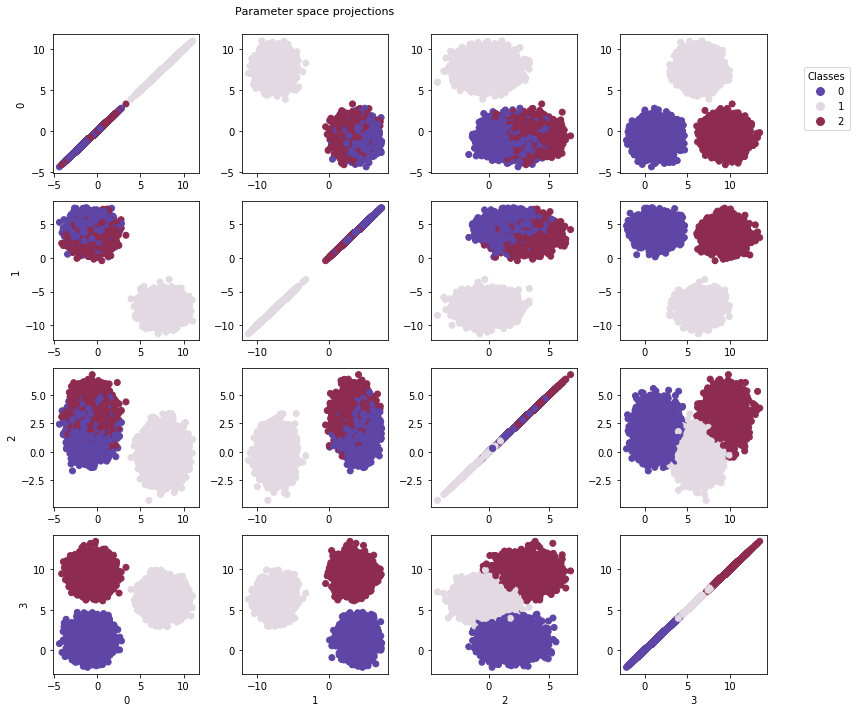

In [8]:
projections_specific(dataset, dataset_name, ["0","1","2","3"])

### Conclusions in the case of the "generated.csv" dataset:
* One of the most important observations to realise when looking at the 2D projections of this dataset, is that in some of the projections **all three classes are perfectly separated** (not only "class 1" as we could see in the histograms of variables "0" and "1").
* This means that it should be **easy to optimize an appropriate model to be able to predict the class**of new data entries. 
* Again, it is clear by the shapes of the different classes that this was a generated set, easy to handle and perfect for tests.

## Other considerations

* All the figures get saved automatically on a folder with the dataset name, so there's an additional function that checks if the folder exists and, if this is not the case, creates it.

* Since all the functions were general, this process can be easily repeated to learn more about each dataset.

# 2. Train the classification model (generated.csv)
I chose to test the a **support vector classification model** from scikit-learn because it's adequate for this task and quite versatile. These models try to find the border between areas corresponding to each class by **maximising the distance from the points of the border**. This allows some margin so that if future data has more extreme values than the training data, that they still get classified correctly. I decided to use the **"linear" kernel** because as observed in the projections, **these classes are already separable in this space without any transformation**.

If the **regularization parameter C is increased**, the border has a tendency to be put closer to the points to help prevent missclassifications of the training data, but this **might be detrimental to proper prediction of future values**, so an equilibrium must be found.

### a) Load the dataset and check imbalance
First I check the dataset and determine if I have to compensate any imbalance with the "weight_advisor". The second variable that returns is the maximum ratio between two classes in the dataset.

In [20]:
dataset, dataset_name = load_file(dataset_files[0])

print(weight_advisor(dataset))

(False, 1.0001500150015001)


In the case of the generated.csv dataset **the classes are balanced** and it will not be necessary.

### b) Check variable scaling and normalize if necessary 
Then I determine if I need to reescale the dataset variables using "scaling_plot", as I showed before.

         min        max   interval
0  -4.400123  11.044036  15.444159
1 -11.219695   7.411504  18.631199
2  -4.276724   6.789665  11.066388
3  -2.116425  13.484701  15.601126


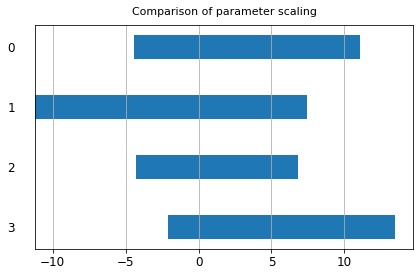

In [21]:
scaling_plot(dataset.iloc[:,:-1], dataset_name)

The variable value ranges are not terribly disparate, so I decide not to reescale the data before analysis.

### c) Separate dataset in a training and validation sets
We want to be able to predict new input data, so we separate the original sample in two sets. One of the sets we will use it to train the model, and the other set we save it for later to try to predict its classes with our model and see if we were successful. We will make this separation randomly assigning points to each group using "train_test_split" from scikit-learn. 

It is not obvious what should be the appropriate split ratio between the training and the test data subsets. I will undertake this discussion on the following sections but, in this simple case, I will arbitrarily **assign 20% of points of the sample to the validations** set, which is a standard guideline in machine learning problems.

Previously, we also need to separate the input variables (X) from the one we want to predict (y).

In [24]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### d) Train model
We start choosing a simple **linear Suport Vector model** and then adjust it training it with the training data. Since we have a **multiclass problem** I specify the "decision_function_shape parameter" to use the **"one-vs-one" approach**. This takes subsets of data corresponding to only a pair of classes to distinguish between them, and then another pair, etc. This is more computationally expensive than the "one-vs-rest" approach, but avoids the imbalance of classifying between data of just one class and all the rest of classes together.

In [25]:
classifier = SVC(kernel='linear', decision_function_shape='ovo')
print(classifier)

classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### e) Evaluate the model
We determine how well the trained model predicts the class of the data that we previously saved for validation. 

1. We start with the **accuracy of the SVC model**. In multiclass problems it's a subset accuracy, where each class must be correctly predicted for every sample. 
2. Then the classification report with the **precision** (from all predicted positives which ones are true), **recall** (from all positives which ones identified correctly), **f1-score** (weighted average of precision and recall, is a better measure for uneven class distributions).

3. And then the **confusion matrix**, which shows which class was predicted for the validation data set compared to the real class.


Score of trained SVC classifier for 'generated': 1.0

Classification report for 'generated': 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1318
           1       1.00      1.00      1.00      1304
           2       1.00      1.00      1.00      1378

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



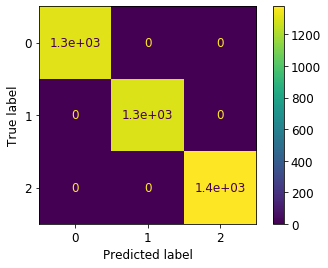

In [26]:
score = classifier.score(X_test, y_test)
print(f"\nScore of trained SVC classifier for '{dataset_name}': {score}")
plot_confusion_matrix(classifier, X_test, y_test)
print(f"\nClassification report for '{dataset_name}': \n\n", classification_report(y_test, y_predicted))

### Conclusions in the case of the "generated.csv" dataset:
* **These metrics show a perfect prediction using a trained SVC linear model with this dataset (100% accuracy).** 

* It was already expected that the problem posed by this generated dataset would be easy to solve, given that the clouds of data points from each class were completely separated in some of the 2D projections. Hence, no surprises from this result.

______

# vehicles.csv
This is a dataset describing geometric features of vehicle silhouettes obtained from photos to carry out image recognition and determine the type of vehicle.

In [27]:
dataset, dataset_name = load_file(dataset_files[1])

# 1. Exploratory analysis of the datasets

## Basic descriptors (vehicles.csv)

In [5]:
table_descriptors(dataset)

print("\nIs it necessary to use weights during training to compensate for an unbalance?")
weight_advisor(dataset)


Dataset shape:  (846, 19)

There are 19 columns: 
['COMPACTNESS', 'CIRCULARITY', 'DISTANCE_CIRCULARITY', 'RADIUS_RATIO', 'PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SCATTER_RATIO', 'ELONGATEDNESS', 'PR.AXIS_RECTANGULARITY', 'MAX.LENGTH_RECTANGULARITY', 'SCALED_VARIANCE_MAJOR', 'SCALED_VARIANCE_MINOR', 'SCALED_RADIUS_OF_GYRATION', 'SKEWNESS_ABOUT_MAJOR', 'SKEWNESS_ABOUT_MINOR', 'KURTOSIS_ABOUT_MAJOR', 'KURTOSIS_ABOUT_MINOR', 'HOLLOWS_RATIO', 'Class']

This dataset has 4 classes: 
['bus', 'opel', 'saab', 'van']
Each class has [218, 212, 217, 199] elements, respectively.

Dataset head:  <bound method NDFrame.head of      COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  RADIUS_RATIO  \
0             95           48                    83           178   
1             91           41                    84           141   
2            104           50                   106           209   
3             93           41                    82           159   
4             85         

(False, 1.0954773869346734)

### Conclusions in the case of the "vehicles.csv" dataset:
* We have a modest volume of data.
* The dataset has many variables (19).
* There are 4 classes, so we will have to use a model that allows **multiclass** classifications.
* The sample is **balanced**.The largest ratio of samples between classes is below 1,1.

## Variable scaling (vehicles.csv)

                             min     max  interval
COMPACTNESS                 73.0   119.0      46.0
CIRCULARITY                 33.0    59.0      26.0
DISTANCE_CIRCULARITY        40.0   112.0      72.0
RADIUS_RATIO               104.0   333.0     229.0
PR.AXIS_ASPECT_RATIO        47.0   138.0      91.0
MAX.LENGTH_ASPECT_RATIO      2.0    55.0      53.0
SCATTER_RATIO              112.0   265.0     153.0
ELONGATEDNESS               26.0    61.0      35.0
PR.AXIS_RECTANGULARITY      17.0    29.0      12.0
MAX.LENGTH_RECTANGULARITY  118.0   188.0      70.0
SCALED_VARIANCE_MAJOR      130.0   320.0     190.0
SCALED_VARIANCE_MINOR      184.0  1018.0     834.0
SCALED_RADIUS_OF_GYRATION  109.0   268.0     159.0
SKEWNESS_ABOUT_MAJOR        59.0   135.0      76.0
SKEWNESS_ABOUT_MINOR         0.0    22.0      22.0
KURTOSIS_ABOUT_MAJOR         0.0    41.0      41.0
KURTOSIS_ABOUT_MINOR       176.0   206.0      30.0
HOLLOWS_RATIO              181.0   211.0      30.0


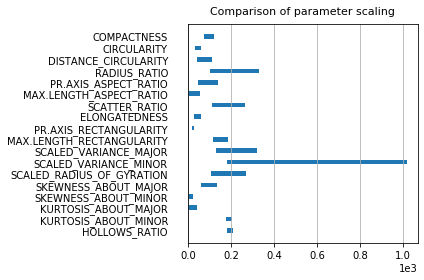

In [72]:
scaling_plot(dataset.iloc[:,:-1], dataset_name)

### Conclusions in the case of the "vehicles.csv" dataset:
* The **scaling between the different variables is quite different**, in some cases even by some orders of magnitude.
* Hence, it will be necessary to **rescale the data** to a similar range before training the model.

## Stacked variable histograms (vehicles.csv)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



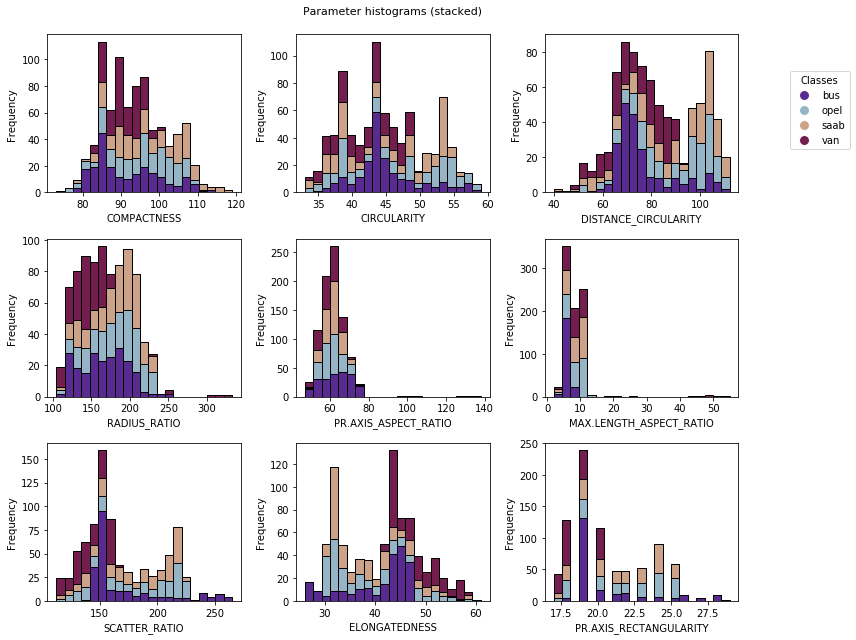


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



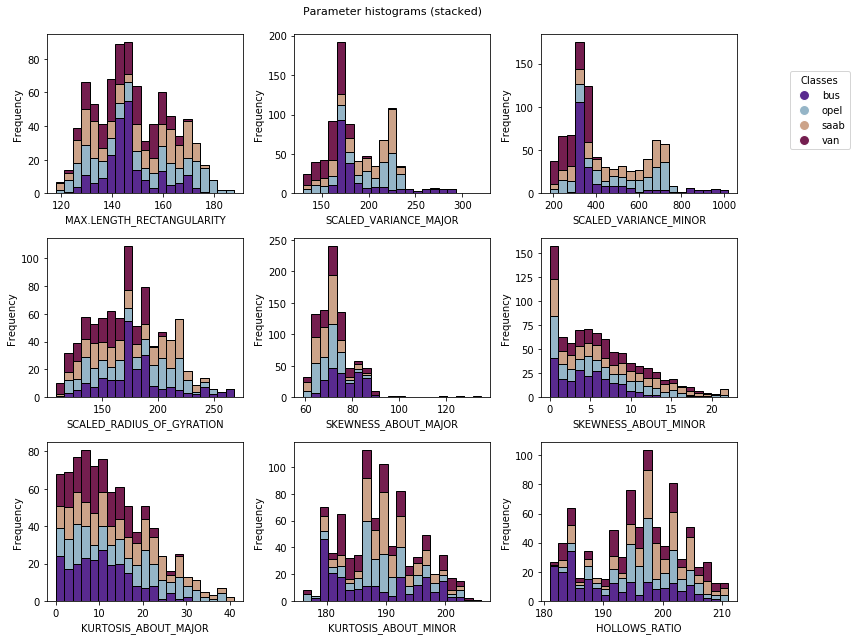

In [13]:
histograms_all(dataset, dataset_name, True, grid=3, bins=21)

### Conclusions in the case of the "vehicles.csv" dataset:
* The classes in this dataset are quite mixed, hence it will probably be **difficult to obtain a good model**.
* Among them, the class **"van"** is in most of the projections **more localized and contributing more to one side than the rest of classes**, so intuitively it seems like it will be the easiest to classify correctly. In all of them the class "van" is contributing more to the left, except in the case of the elongatedness (see compactness, circularity, distance circularity, radius ratio, scatter ratio, elongatedness, pr. axis rectangularity, scaled variance major and minor, and scale radius of gyration). 
  
* The class **"bus"** also shows several **distinct features**, displaying a much more significant contribution in certain particular values than the rest (see circularity, distance circularity, max. length aspect ratio, scatter ratio, elongatedness, pr. axis rectangularity, max. length rectangularity, scaled variance major and minor, scaled radius of gyration, kurtosis about minor, hollows ratio).


* The **"opel"** and **"saab"** classes don't appear to have many distinct features and are very similar to each other. Hence, they are expected to be very difficult to distinguish even by a trained model.

## Overlapping variable histograms (generated.csv)

If we try to use for the projections in this case a larger number of bins to appreciate the class distributions, we can see that it doesn't work very well. Below we can see a comparison of a few variables with the same binings (100 bins above and 17 bins below). Even grouping the data between very few bins the "pr. axis rectangularity" variable still **appears as discrete**.


You chose a 2x2 grid, the histograms will be calculated maximum 4 at a time.



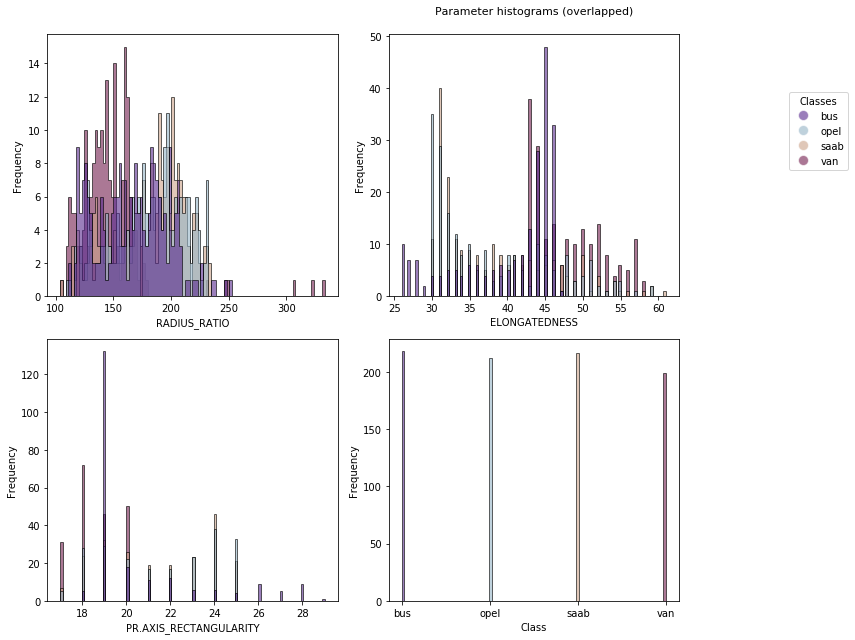


You chose a 2x2 grid, the histograms will be calculated maximum 4 at a time.



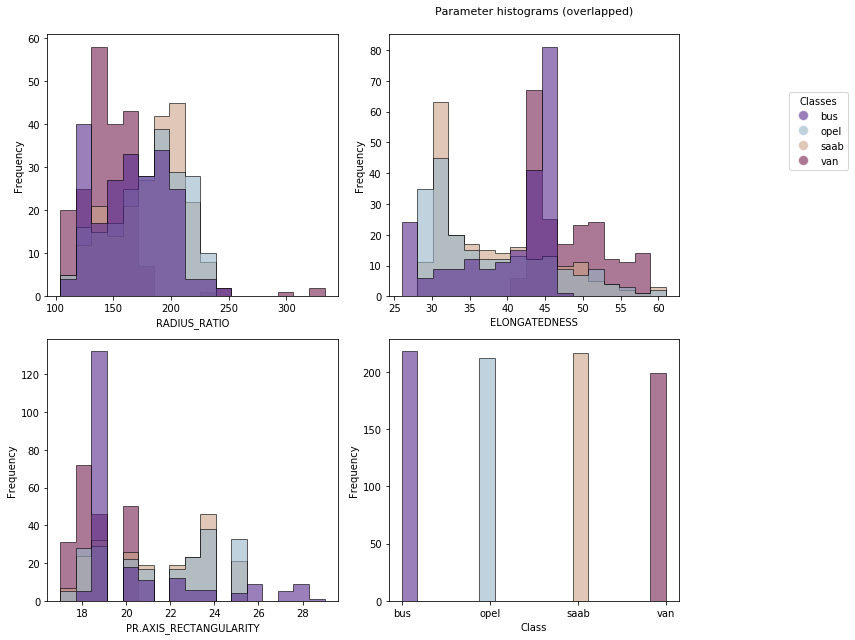

In [14]:
histograms_specific(dataset, dataset_name, False, ["RADIUS_RATIO", "ELONGATEDNESS", "PR.AXIS_RECTANGULARITY"], grid=2, bins=100)
histograms_specific(dataset, dataset_name, False, ["RADIUS_RATIO", "ELONGATEDNESS", "PR.AXIS_RECTANGULARITY"], grid=2, bins=17)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



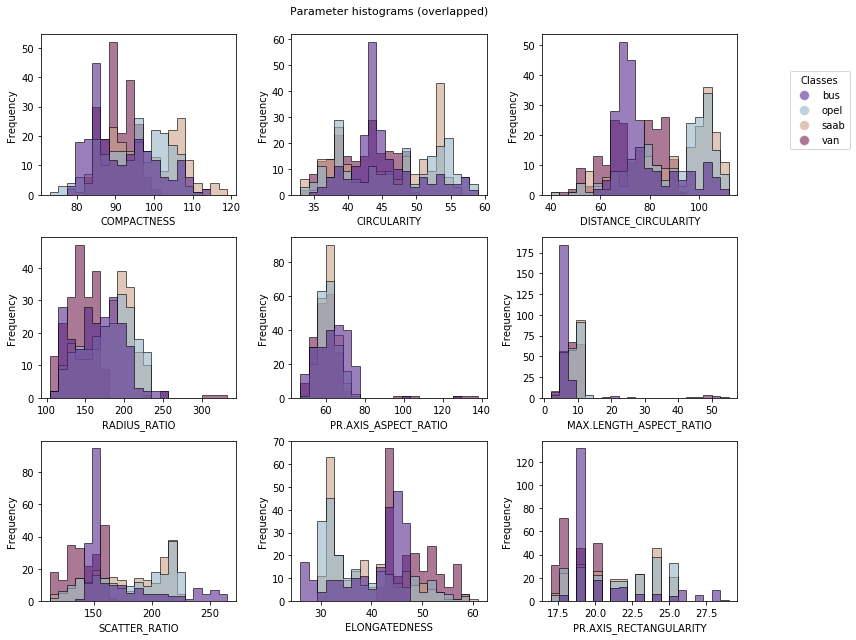


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



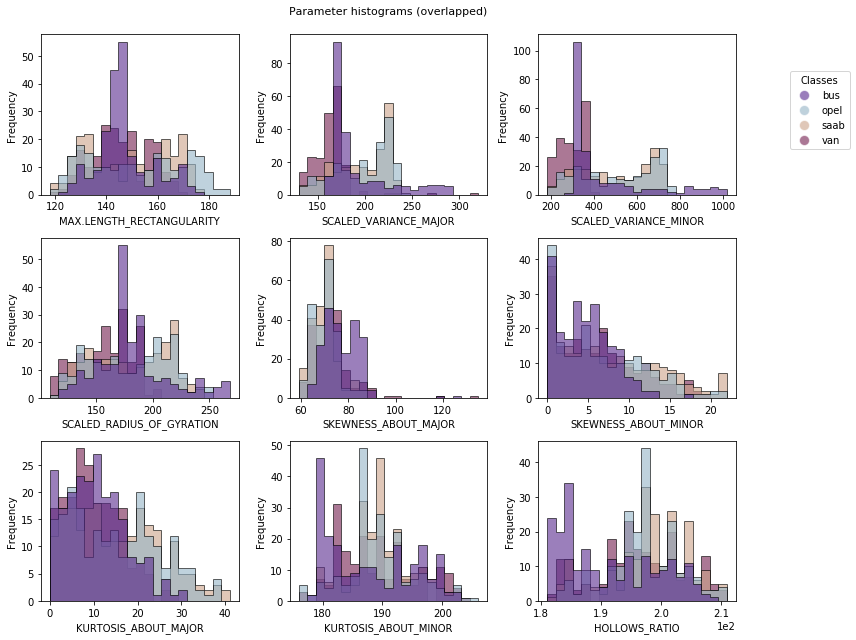

In [15]:
histograms_all(dataset, dataset_name, False, grid=3, bins=21)

We take a look to the histograms of all variables to have an overview. 

### Conclusions in the case of the "vehicles.csv" dataset:
* The variable distributions appear to have very **irregular shapes**.

* The fact that the dataset is not very big and there are not many data points hinders apreciation of the different distributions. 

* This dataset has the characteristic that **all variable values have been taken as integers** albeit they have different magnitudes, which means that some variables have a reasonable precision while others behave like a discrete distribution. 

* I have used few bins but the saw-like contour corresponding to an **underlying discrete distribution** is still visible for many of the variables.

## 2D projections of the variable space (vehicles.csv)


There are 18 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


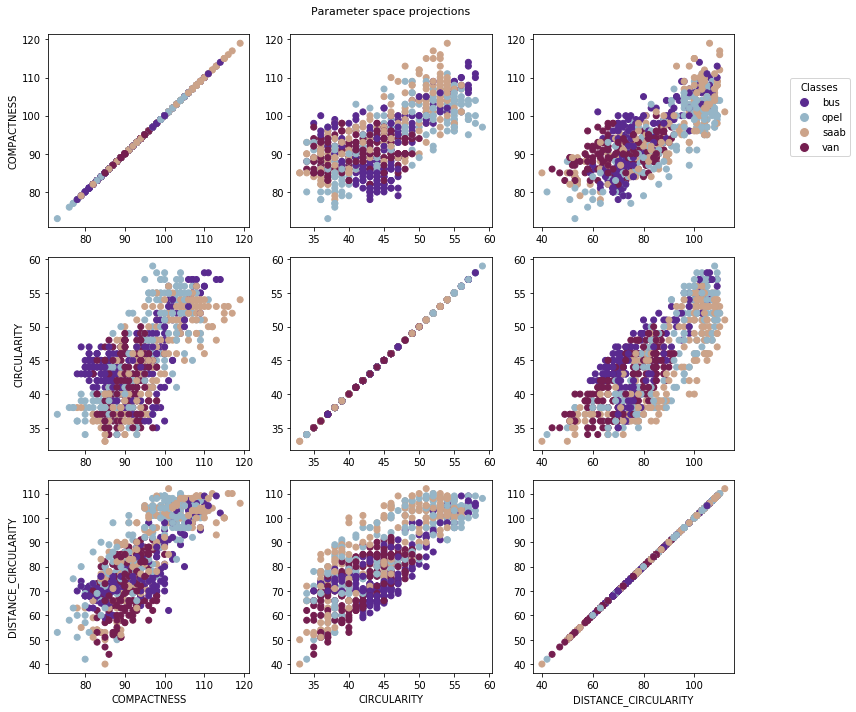


There are 18 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


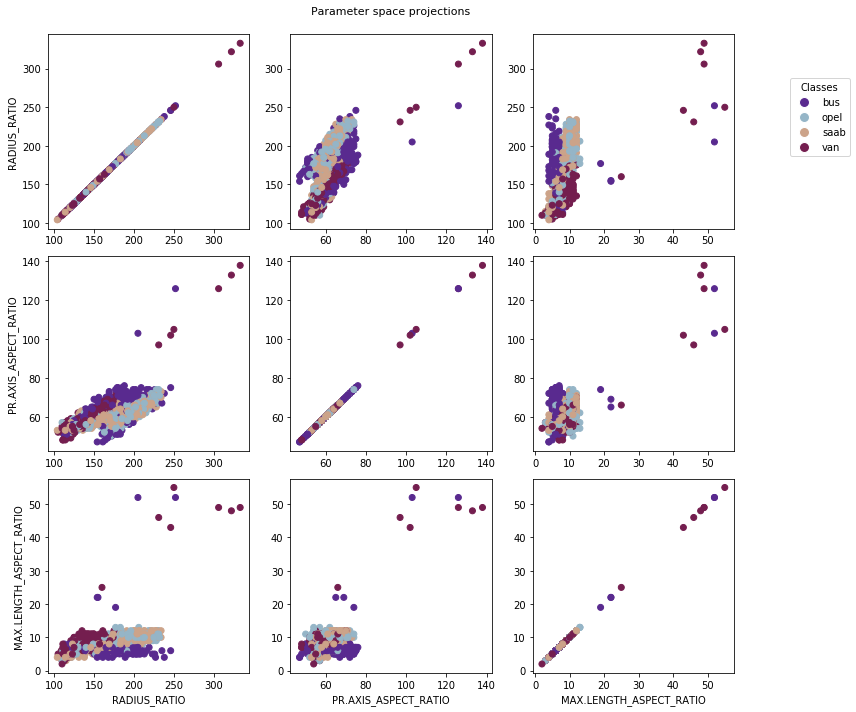


There are 18 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


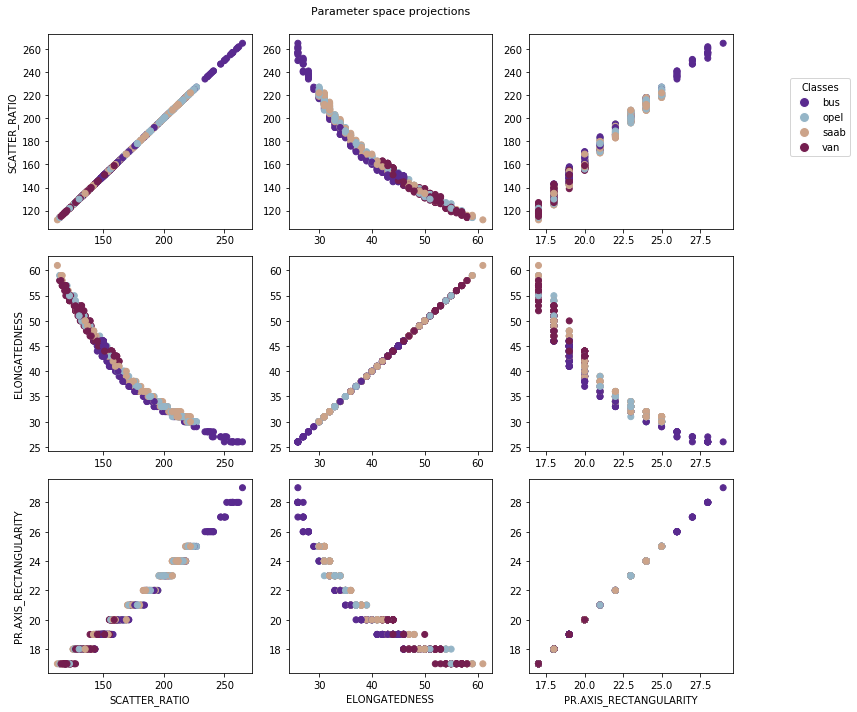


There are 18 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


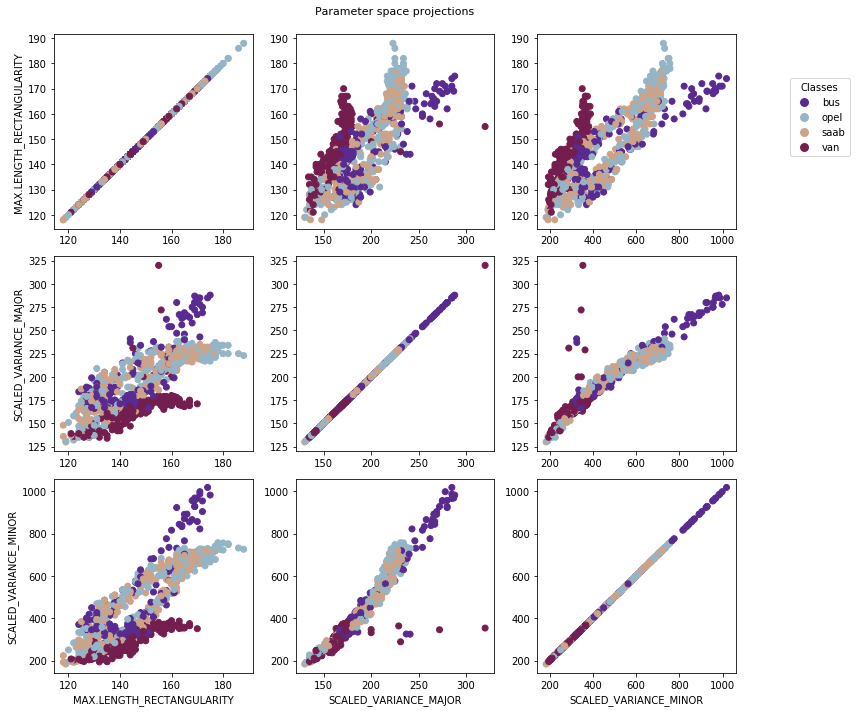


There are 18 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


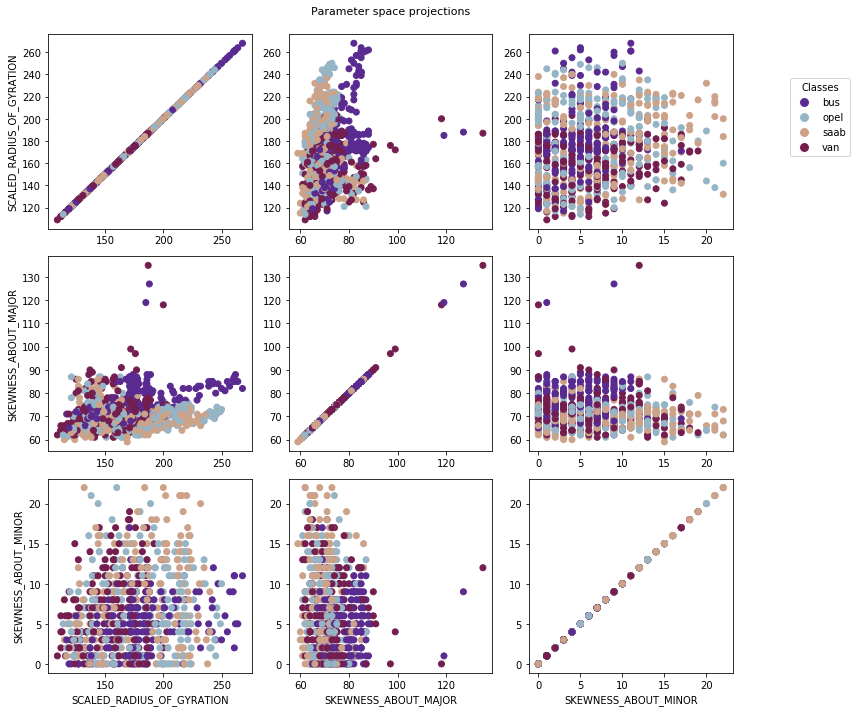


There are 18 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


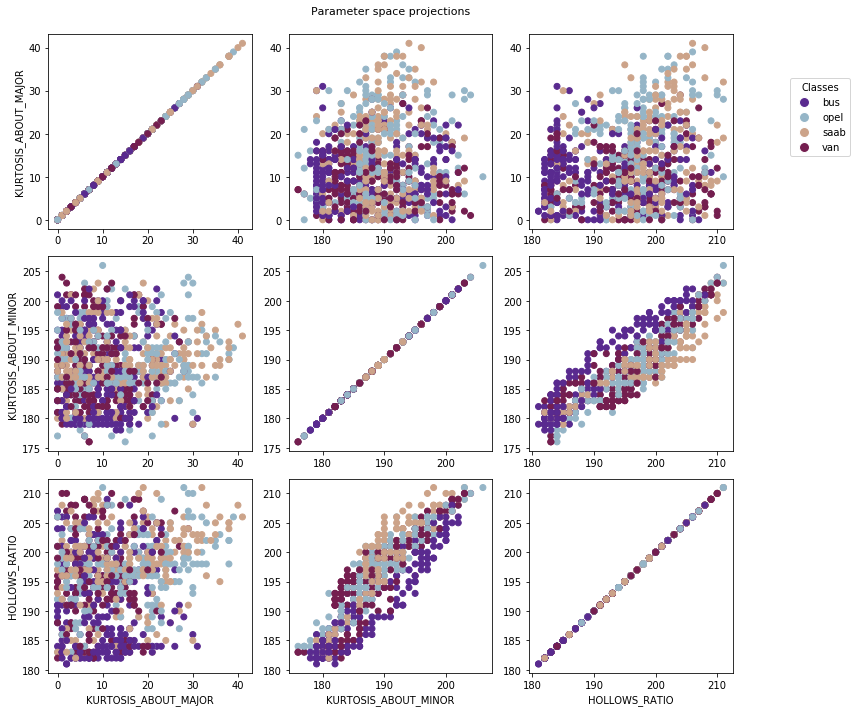

In [16]:
projections_all(dataset, dataset_name, grid = 3)

### Conclusions in the case of the "vehicles.csv" dataset:
* A **"van" class cluster can be seen in 5 of the projections** (radius ratio & pr. axis aspect ratio, radius ratio & max. length aspect ratio, max. length rectangularity & scaled variance major/minor, and scaled variance major & scaled variance minor).

* Here it can also be seen again that the **"van"** and **"bus"** classes, although having some common features, form **identificable clusters** in some of the projections, in contrast with the **"opel"** and **"saab"** classes which are **extremely mixed**.

* There seem to be a number of **outlier data points** visible in several of the projections.

* We observe a **strong correlation** between the variables scatter ratio & pr. axis rectangularity, scatter ratio & elongatedness, and scaled variance major & scaled variance minor.
* **Some correlation** between compactness & distance circularity, circularity & distance circularity, and kurtosis about minor & hollows ratio.

*  **Inverse correlation** between the variables "scatter ratio" and "elongatedness".

* All these correlations and inverse correlations between the variables imply that **we have less information** that we thought to carry out the prediction.



# 2. Train the classification model (vehicles.csv)
I will also use **support vector classification model** from scikit-learn, starting with the **"linear" kernel** to compare the results with the previous dataset.

### a) Load the dataset and check imbalance
First I check the dataset and determine if I have to compensate any imbalance with the "weight_advisor". The second variable that returns is the maximum ratio between two classes in the dataset.

In [28]:
dataset, dataset_name = load_file(dataset_files[1])

print(weight_advisor(dataset))

(False, 1.0954773869346734)


As we have seen before, **the dataset is balanced** and it would not be necessary to weight the classes during the 
training.

### b) How to split the dataset in a training and validation sets?

As was mentioned before, **the optimal ratio** to split the data between the **training and the test data** subsets is **not an obvious issue**. And this becomes even more relevant whith **small or moderate volume** datasets.

Using more data to train the model helps to obtain more accurate models, yielding less variance in the model parameters, but with less data to assess the model, it is the performance's evaluation which ends up having a larger variance. Therefore, it is necessary to find an **equilibrium**.

To have more information to take this decision, I have **systematically explored the test/train data split ratio** of the sample by:

1. Taking a collection of different split ratios.
2. Training a linear SVC model for each ratio (with weights during training to compensate any imbalance).
3. Repeating the random splitting and training several times for each of these ratios with a different random seed and averaging them, in order to have a measure of the variance.

Also, the variables were reescaled beforehand to the same standard range using the "StandardScaler".

The idea is to take into account both, **the performance of the model and a small variance of the evaluation metrics**, in order to decide which is the optimal ratio.

To facilitate the use of this strategy for all datasets, I've written the function **explore_test_split_ratio(dataset, dataset_name, num_test_fractions, random_tries)** that does this task automatically:

* The user indicates a number of test data fractions to be explored (**num_test_fractions**), which will be evenly distributed between 0 and 1.
* As usual, **the separation is made randomly** assigning points to each group using "train_test_split" from scikit-learn. 
* The user also indicates how many **repetitions of random data splitting** (**random_tries**) and subsequent model trainings to perform.
* Since these systematic calculations may be quite resource-expensive depending on the dataset, for convenience I've also included an estimation of the duration.

0:00:00.018114 (hh:mm:ss.ss) for 1 iteration/s. 
There are 5999 iterations left. 
Estimated total running time: 0:01:12.456000 (hh:mm:ss.ss)
Real total running time: 0:01:17.527949 (hh:mm:ss.ss)


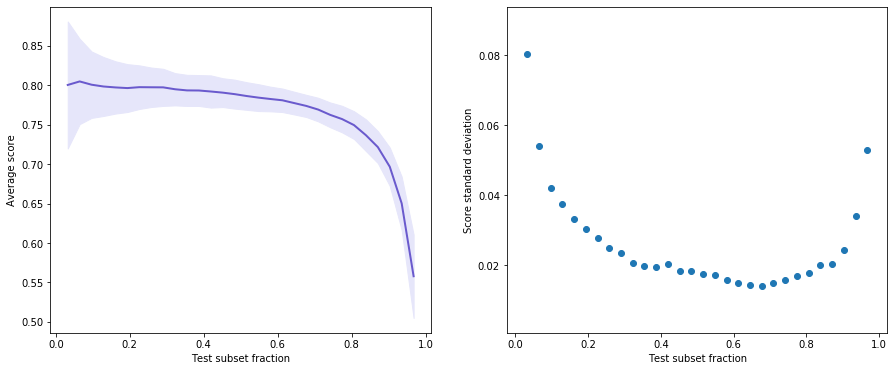


Index of point where score has the smallest standard deviation: 20

Test fraction where score has smallest standard deviation: 0.6774
Average score at test fraction with the smallest standard deviation: 0.7738


In [5]:
score_summary = explore_test_split_ratio(dataset, dataset_name, 30, 200)

### Conclusions in the case of the "vehicles.csv" dataset:

* On the left, we have the average score of the trained model with the test dataset as a function of the fraction.
* In this case, I have explored 30 different fractions, and I've used 200 random data subsets for each fraction. 
* Obviously, the model has a better performance as we decrease the test fraction an more data is available for the training, however, it can be clearly seen that around 0.5 this increment is not that notorious and the performance is close to a platteau.
* The greyed area on the left is a representation of the standard deviation of the collection of random trials for each fraction. 
* On the right, a better view of the standard deviation as a function of the test fraction.
* The standard deviation increases rapidly as the test dataset becomes small. But it also increases when it's too big and the training data decreases too much.

  Therefore, I will **assign 40% of points of the sample to the validations** set. There, the score is close to the maximum and the variance of the performance statistics of the model are also close to the minimum. 

In [29]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

### c) Check variable scaling and standardize the dataset
As we've previously seen with the **scaling plot()**, the variables of this dataset **need to be reescaled**. 

                             min     max  interval
COMPACTNESS                 73.0   119.0      46.0
CIRCULARITY                 33.0    59.0      26.0
DISTANCE_CIRCULARITY        40.0   112.0      72.0
RADIUS_RATIO               104.0   333.0     229.0
PR.AXIS_ASPECT_RATIO        47.0   138.0      91.0
MAX.LENGTH_ASPECT_RATIO      2.0    55.0      53.0
SCATTER_RATIO              112.0   265.0     153.0
ELONGATEDNESS               26.0    61.0      35.0
PR.AXIS_RECTANGULARITY      17.0    29.0      12.0
MAX.LENGTH_RECTANGULARITY  118.0   188.0      70.0
SCALED_VARIANCE_MAJOR      130.0   320.0     190.0
SCALED_VARIANCE_MINOR      184.0  1018.0     834.0
SCALED_RADIUS_OF_GYRATION  109.0   268.0     159.0
SKEWNESS_ABOUT_MAJOR        59.0   135.0      76.0
SKEWNESS_ABOUT_MINOR         0.0    22.0      22.0
KURTOSIS_ABOUT_MAJOR         0.0    41.0      41.0
KURTOSIS_ABOUT_MINOR       176.0   206.0      30.0
HOLLOWS_RATIO              181.0   211.0      30.0


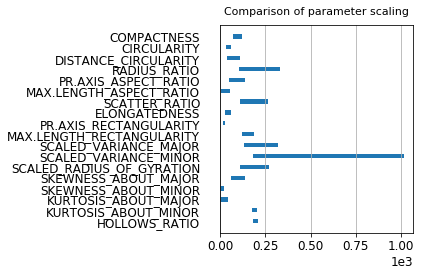

In [30]:
scaling_plot(dataset, dataset_name)

I've used the **StandardScaler** from the scikit-library, it transforms the data so it has **zero mean and unit variance**. The scaler is fitted to the training data which can then be transformed, but afterwards **the same transformation has to be applied to the validation data**.

In [31]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

### d) Train model
I start with the same simple **linear Suport Vector model** and then adjust it training it with the training data. Like before, since we have a **multiclass problem** I specify the "decision_function_shape parameter" to use the **"one-vs-one" approach**.

In [32]:
classifier = SVC(kernel='linear', decision_function_shape='ovo')
print(classifier)

classifier.fit(X_train_scaled, y_train)
y_predicted = classifier.predict(X_test_scaled)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### e) Evaluate the model
We determine how well the trained model predicts the class of the data that we previously saved for validation. 

1. Using the **accuracy of the SVC model** (in multiclass a subset accuracy).
3. Report with **precision**, **recall**, and **f1-score**.
2. And the **confusion matrix** (compares predicted vs real class of the validation data).


Score of trained SVC classifier for 'vehicles': 0.7787610619469026

Classification report for 'vehicles': 

               precision    recall  f1-score   support

         bus       0.93      0.95      0.94        82
        opel       0.62      0.66      0.64        87
        saab       0.66      0.58      0.62        96
         van       0.94      0.99      0.96        74

    accuracy                           0.78       339
   macro avg       0.79      0.79      0.79       339
weighted avg       0.77      0.78      0.78       339



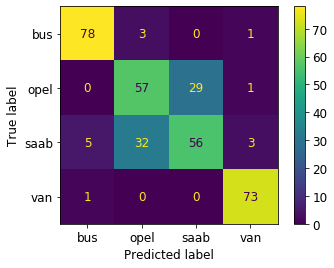

In [34]:
score = classifier.score(X_test_scaled, y_test)
print(f"\nScore of trained SVC classifier for '{dataset_name}': {score}")
plot_confusion_matrix(classifier, X_test_scaled, y_test)
print(f"\nClassification report for '{dataset_name}': \n\n", classification_report(y_test, y_predicted))

### Conclusions in the case of the "vehicles.csv" dataset:
* These metrics show a **reasonably good prediction** using a trained SVC linear model with this dataset (**77.9% accuracy**). 
* The confusion matrix shows that from 339 test data points, the class prediction was accurate for 264 of them and that 75 were incorrectly classified.
* The confusion matrix also agrees with our prediction that **the "van" class was the easiest to predict, followed by the "bus" class**. Only 5 vehicles were misclassified as vans, and with regards to the bus class, 6 vehicles were misclassified as busses, and there was a 1 van i 4 busses respectively that were wrongly predicted as something else.

* It also shows that the **"opel"** and **"saab"** classes are the most dificult to classify correctly.

______

#  eeg.csv
This is a dataset corresponding to a single continuous electroencephalographic (EEG) measurement (117 seconds) carried out to try to predict when the eyes of the subject are open (0) or closed (1). The headset allowed to measure 14 simultaneous EEG signals. The data is in chronological order.

In [35]:
dataset, dataset_name = load_file(dataset_files[2])

# 1. Exploratory analysis of the datasets

## Basic descriptors (eeg.csv)

In [12]:
table_descriptors(dataset)

print("\nIs it necessary to use weights during training to compensate for an unbalance?")
weight_advisor(dataset)


Dataset shape:  (14976, 15)

There are 15 columns: 
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'Class']

This dataset has 2 classes: 
[1, 2]
Each class has [8254, 6722] elements, respectively.
There is a class with 1.2 times more samples than another.

Dataset head:  <bound method NDFrame.head of             V1       V2       V3       V4       V5       V6       V7       V8  \
0      4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1      4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2      4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3      4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4      4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14971  4281.03  3990.26  4245.64  4116.92  4333.85  4614.36  4074.87  4625.64   
14972 

(False, 1.2279083606069623)

### Conclusions in the case of the "eeg.csv" dataset:
* There are only 2 classes, eyes open (1) or closed (2), so in principle we could use a **binary classifier**.
* The sample is **slightly unbalanced** but is not too bad.The largest ratio of samples between classes is 1,2.

## Variable scaling (eeg.csv)

         min      max  interval
V1   4197.95  4504.10    306.15
V2   3905.64  4156.92    251.28
V3   4197.44  4386.15    188.71
V4   4058.46  4250.26    191.80
V5   4304.62  4463.59    158.97
V6   4566.15  4756.92    190.77
V7   4026.15  4178.46    152.31
V8   4567.18  4731.79    164.61
V9   4147.69  4320.00    172.31
V10  4152.82  4362.56    209.74
V11  4100.00  4332.31    232.31
V12  4201.03  4397.95    196.92
V13  4443.08  4833.85    390.77
V14  4205.64  4573.33    367.69


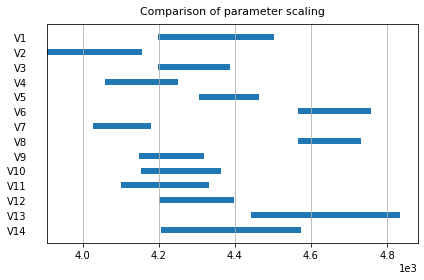

In [81]:
scaling_plot(dataset.iloc[:,:-1], dataset_name)

### Conclusions in the case of the "egg.csv" dataset:
* The scaling is **not consistent across all variables**, but it's not too bad. We will reescale the data to ensure a better fit of the model.

## Stacked variable histograms (eeg.csv)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



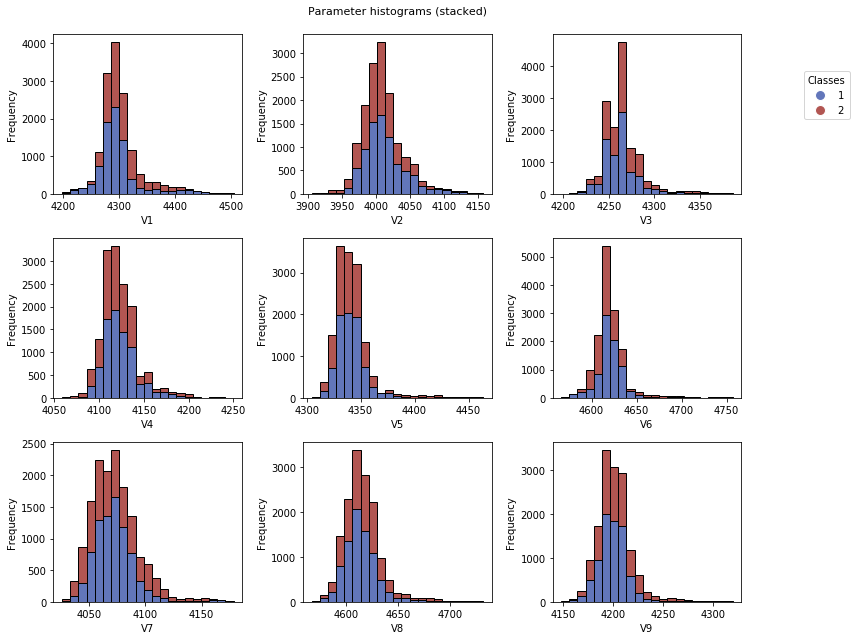


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



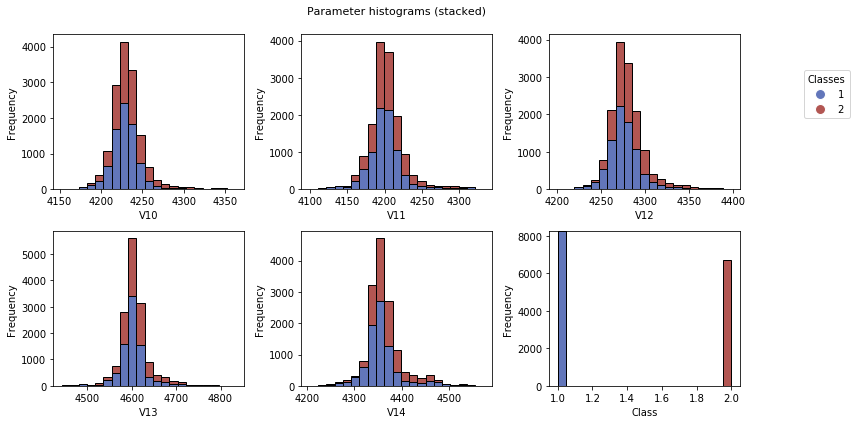

In [20]:
histograms_all(dataset, dataset_name, True, grid=3, bins=21)

### Conclusions in the case of the "eeg.csv" dataset:
* The classes in this dataset are quite mixed, hence we expect it to be **difficult to obtain a good predictive model**.


## Overlapping variable histograms (eeg.csv)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



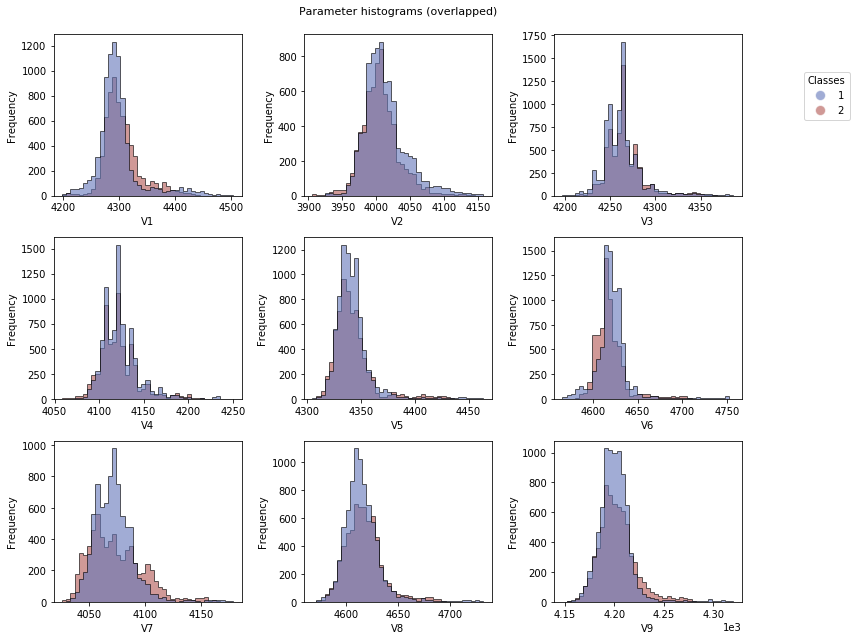


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



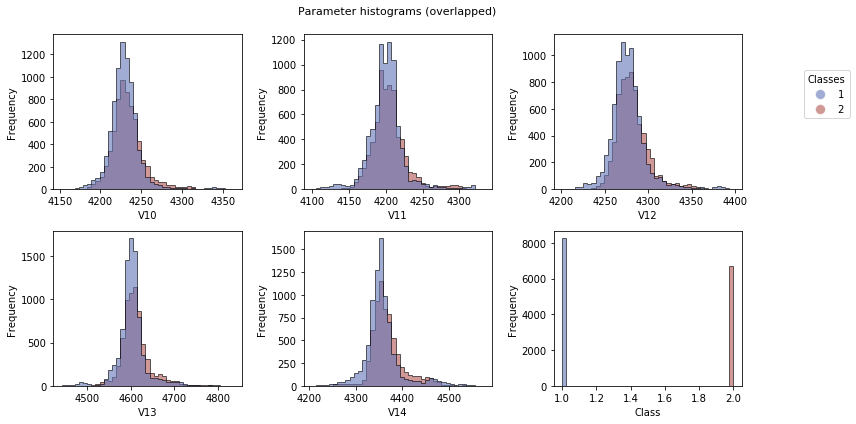

In [21]:
histograms_all(dataset, dataset_name, False, grid=3, bins=41)

### Conclusions in the case of the "eeg.csv" dataset:

* The variable distributions appear to have a **very similar peak shape for both classes**, except perhaps a slight difference for variables V6, V7 and v8.

* Class 1 is somewhat more populated so its histogram peaks are higher.

## 2D projections of the variable space (eeg.csv)


There are 14 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


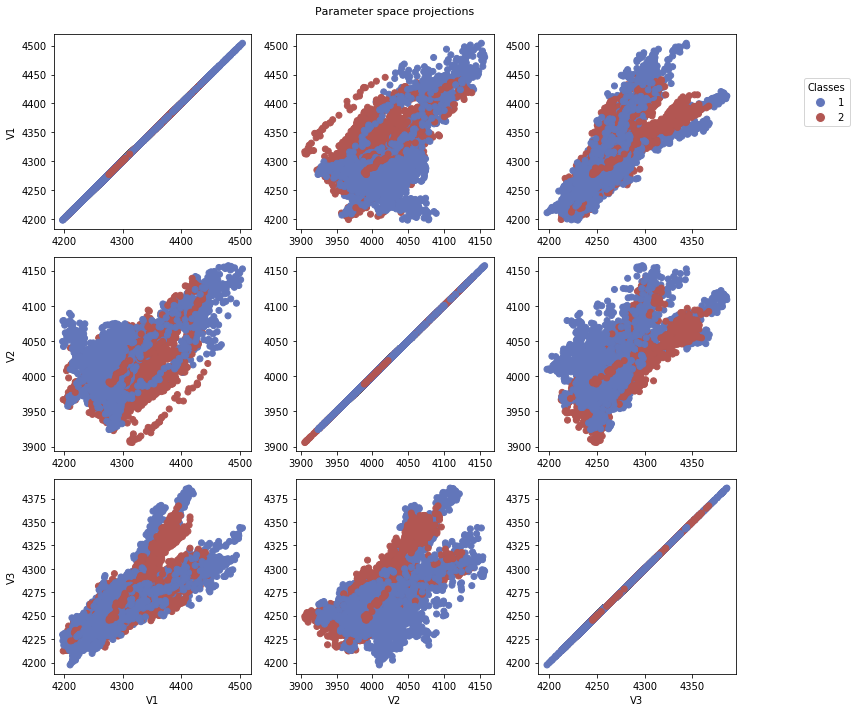


There are 14 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


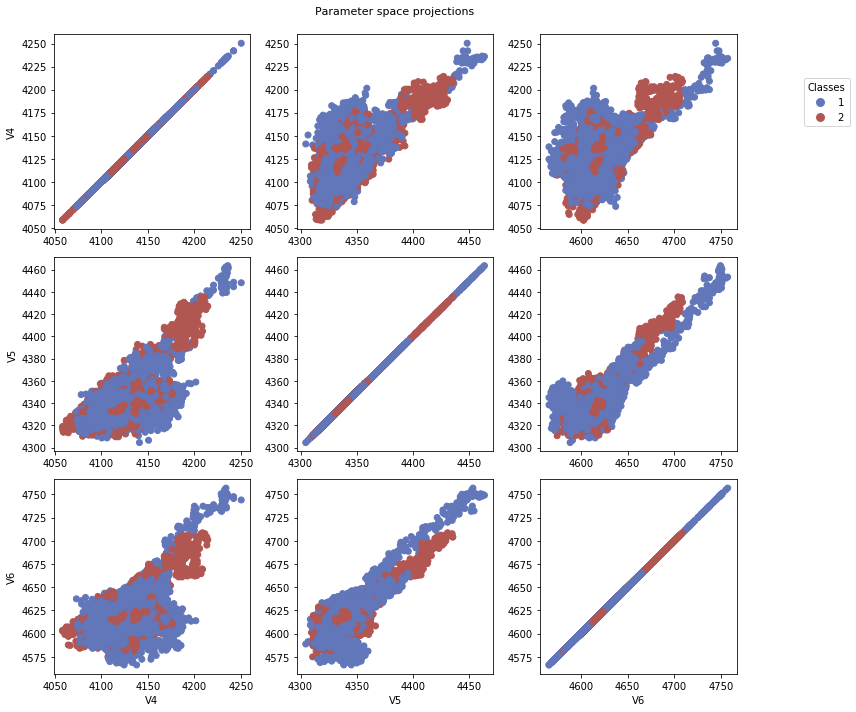


There are 14 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


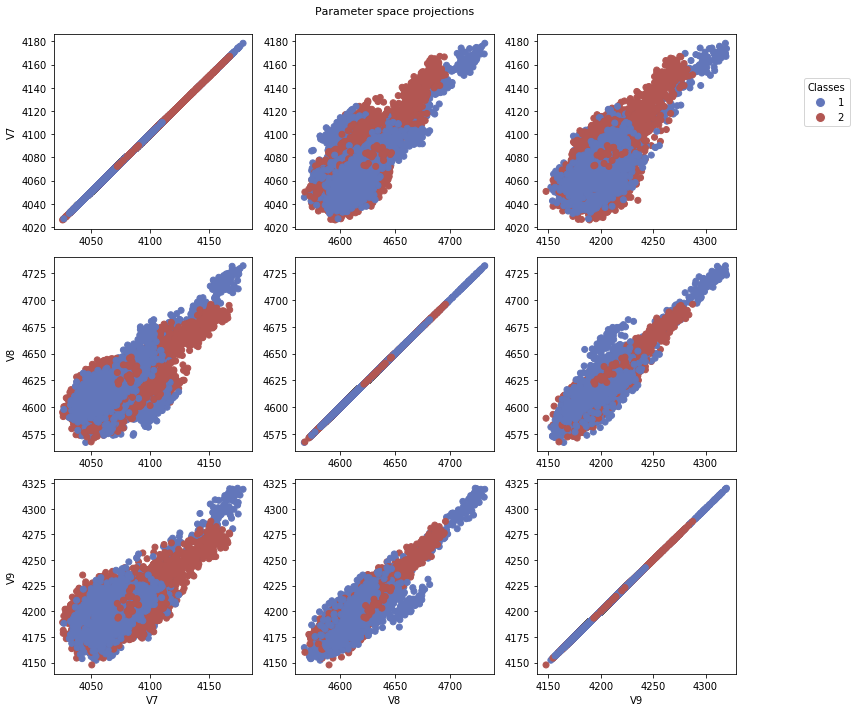


There are 14 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


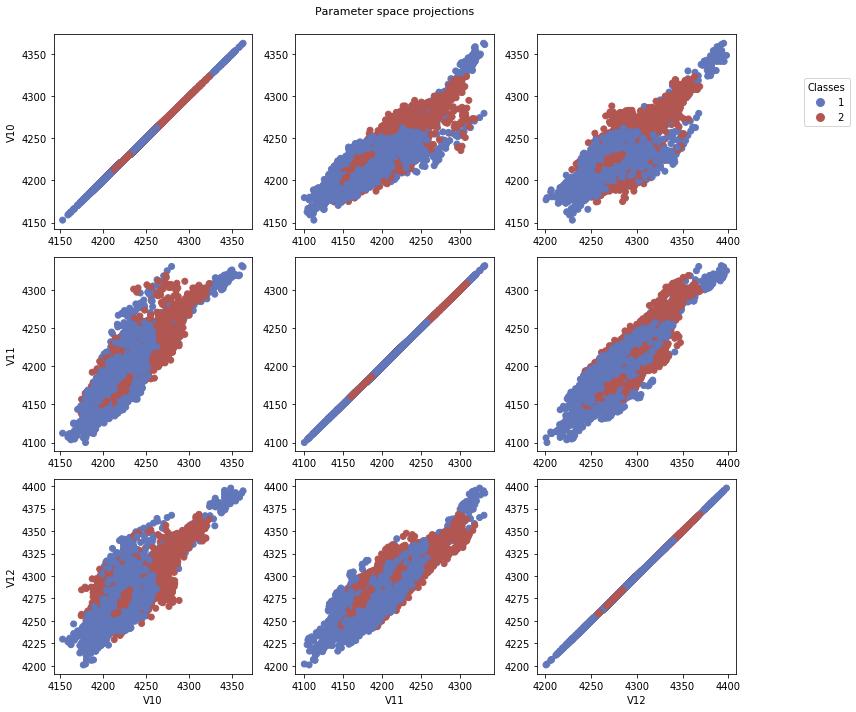


There are 14 variables in this dataset.
Only the crossed projections of 2 parameters at a time will be plotted.


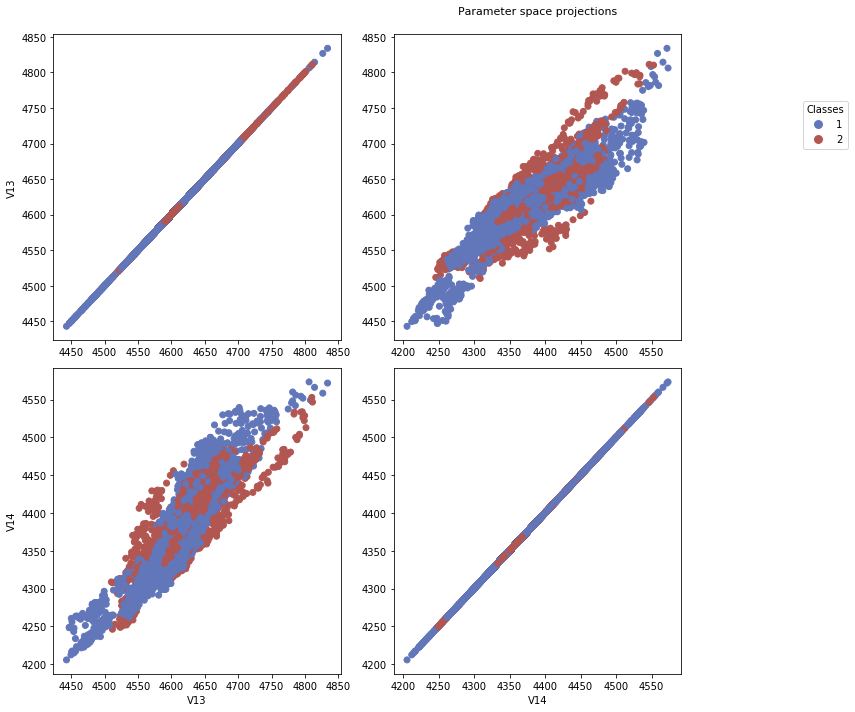

In [22]:
projections_all(dataset, dataset_name, grid=3)

### Conclusions in the case of the "eeg.csv" dataset:
* The data points from both classes seems **rather entangled** across all projections, although there are regions with more dominance of one class or the other.

* There is **some correlation for most variable pairs** which, as mentioned before, hints that there is **less information** in the dataset than appears.

# 2. Train the classification model (eeg.csv)
I will also use **support vector classification model** from scikit-learn, starting with the **"linear" kernel** to compare the results with the previous datasets.

### a) Load the dataset and check imbalance
First I check the dataset and determine if I have to compensate any imbalance with the "weight_advisor". The second variable that returns is the maximum ratio between two classes in the dataset.

In [51]:
dataset, dataset_name = load_file(dataset_files[2])

print(weight_advisor(dataset))

(False, 1.2279083606069623)


As we have seen before with the scaling_plot, **the dataset is not completely balanced**.

### b) Separate dataset in a training and validation sets
We will make this separation **randomly** assigning points to each group using "train_test_split" from scikit-learn. Like in the previous example, I will explore the effect of the test fraction split on the average score and standard deviation.

0:00:08.361790 (hh:mm:ss.ss) for 1 iteration/s. 
There are 199 iterations left. 
Estimated total running time: 0:18:34.905333 (hh:mm:ss.ss)
Real total running time: 0:13:46.172781 (hh:mm:ss.ss)


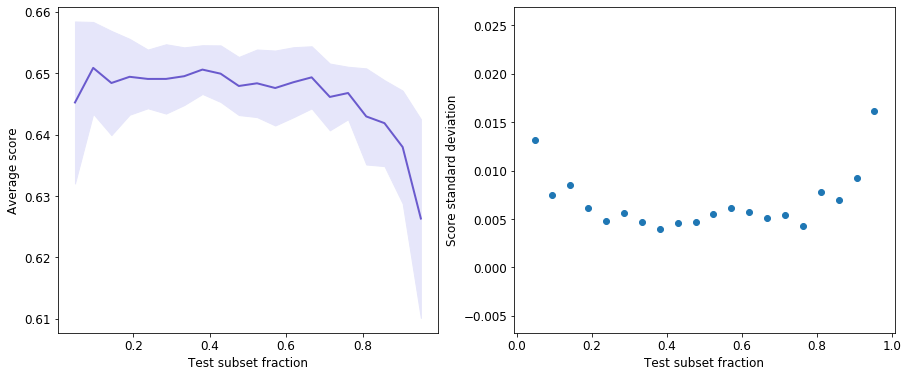


Index of point where score has the smallest standard deviation: 7

Test fraction where score has smallest standard deviation: 0.3810
Average score at test fraction with the smallest standard deviation: 0.6506


In [27]:
score_summary = explore_test_split_ratio(dataset, dataset_name, 20, 10)

### Conclusions in the case of the "eeg.csv" dataset:

* The average score also reaches a plateau of sorts as it decreases.
* The standard deviation has a very similar shap as the "vehicles.csv" dataset, it increases for extreme values, and it's lower for intermediate values.
* The test fraction around 0,38 is the one that has the highest average score,  and it's simultanously one of the fractions with the lowest standard deviation. Therefore, I will **assign 38% of points of the sample to the validations** set. 

In [52]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=0)

### c) Check variable scaling and standardize the dataset
As we've previously seen with the **scaling plot()**, the variables of this dataset **need to be reescaled**. 


I've used the **StandardScaler** from the scikit-library, it transforms the data so it has **zero mean and unit variance**. The scaler is fitted to the training data which can then be transformed, but afterwards **the same transformation has to be applied to the validation data**.

In [53]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

### d) Train model
I start with the same simple **linear Suport Vector model** and then adjust it training it with the training data. Since now we have a **binary classification problem** we can let the "decision_function_shape parameter" to use the **"one-vs-rest" approach**. 

In [54]:
classifier = SVC(kernel="linear", decision_function_shape="ovr")
print(classifier)

classifier.fit(X_train_scaled, y_train)
y_predicted = classifier.predict(X_test_scaled)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### e) Evaluate the model
We determine how well the trained model predicts the class of the data that we previously saved for validation. 

1. Using the **accuracy of the SVC model** (in multiclass a subset accuracy).
2. Report with **precision**, **recall**, and **f1-score**.
3. And the **confusion matrix** (compares predicted vs real class of the validation data).
4. For binary classifications a **Receiving Operating Characteristic (ROC) curve** can be used. The **Area Under the Curve (AUC)** gives the probability that the model can discriminate between the two classes.


Score of trained SVC classifier for 'eeg': 0.6573537163943068

Classification report for 'eeg': 

               precision    recall  f1-score   support

           1       0.64      0.85      0.73      3100
           2       0.70      0.43      0.53      2591

    accuracy                           0.66      5691
   macro avg       0.67      0.64      0.63      5691
weighted avg       0.67      0.66      0.64      5691



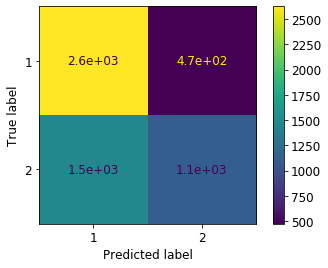

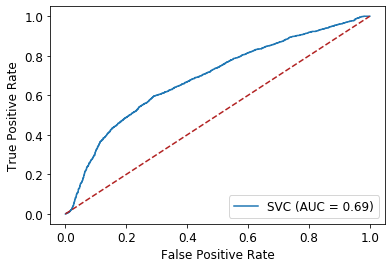

In [55]:
score = classifier.score(X_test_scaled, y_test)
print(f"\nScore of trained SVC classifier for '{dataset_name}': {score}")
plot_confusion_matrix(classifier, X_test_scaled, y_test)
print(f"\nClassification report for '{dataset_name}': \n\n", classification_report(y_test, y_predicted))
figura_roc = plot_roc_curve(classifier, X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], color='firebrick', linestyle='--')

### Conclusions in the case of the "eeg.csv" dataset:
* These metrics show a **poor prediction** using a trained SVC linear model with this dataset (**65.7% accuracy**). Although somewhat better than a random assignment of the class.
* The Area Under the Curve (AUC) of the Receiving Operating Characteristic (ROC) curve is 0,69.

### Additional coment:
A special thing about this dataset is that **the data points are not independent** from one another, **they are ordered chronologically** instead. We break this dependence by shuffling the points around randomly when we divide the data into the train and test sets.

If the correlation between contiguous points were present it could significantly affect the training of the model. The appropriatness of respecting this chronological order without shuffling the data points is debated. 

Is clear that information is lost by shuffling. However, given a particular point in the temporal series, it could be argued that it is only legitimate to use the precedent points to train a model and make predictions but not the subsequent ones, because it would be like accessing the future to fit the model and make the prediction.

Reference: Jason Brownlee, "A Case Study in How to Avoid Methodological Errors when Evaluating Machine Learning Methods for Time Series Forecasting", https://machinelearningmastery.com/how-to-predict-whether-eyes-are-open-or-closed-using-brain-waves/

______

#  winequality.csv
This is a dataset corresponding to physico-chemical properties of a series of Portuguese white wines. The goal is to predict its quality. 

Although there is a multiclass assessing the wine quality itself, I will use the binary classification regarding whether the wine is recommended or not (which is derived from a threshold of 7 in the quality classification). Therefore, I will drop the "quality" column from the dataset to prevent it from causing any distortion on the results.

In [5]:
dataset, dataset_name = load_file(dataset_files[3])
dataset = dataset.drop(columns=["quality"])

# 1. Exploratory analysis of the datasets

## Basic descriptors (winequality.csv)

In [6]:
table_descriptors(dataset)

print("\nIs it necessary to use weights during training to compensate for an unbalance?")
weight_advisor(dataset)


Dataset shape:  (4898, 12)

There are 12 columns: 
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'recommend']

This dataset has 2 classes: 
[False, True]
Each class has [3838, 1060] elements, respectively.
There is a class with 3.6 times more samples than another.

Dataset head:  <bound method NDFrame.head of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ..

(False, 3.620754716981132)

### Conclusions in the case of the "winequality.csv" dataset:
* There are only 2 classes, recommended (True) and not recommended (False), so in principle we could use a **binary classifier**.
* This sample is **quite unbalanced**, there are 3,6 times more wines not recommended than recommended. Therefore, we will use **weights** during the training of the model to compensate.

## Variable scaling (winequality.csv)

                          min        max   interval
fixed acidity         3.80000   14.20000   10.40000
volatile acidity      0.08000    1.10000    1.02000
citric acid           0.00000    1.66000    1.66000
residual sugar        0.60000   65.80000   65.20000
chlorides             0.00900    0.34600    0.33700
free sulfur dioxide   2.00000  289.00000  287.00000
total sulfur dioxide  9.00000  440.00000  431.00000
density               0.98711    1.03898    0.05187
pH                    2.72000    3.82000    1.10000
sulphates             0.22000    1.08000    0.86000
alcohol               8.00000   14.20000    6.20000


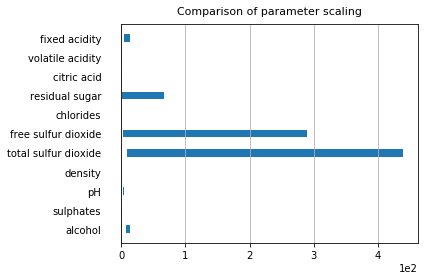

In [90]:
scaling_plot(dataset.iloc[:,:-1], dataset_name)

### Conclusions in the case of the "winequality.csv" dataset:
* The scaling is also **quite disparate for most variables**, in some cases of several orders of magnitude. Hence, we must reescale the data to ensure a better fit of the model.

## Stacked variable histograms (winequality.csv)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



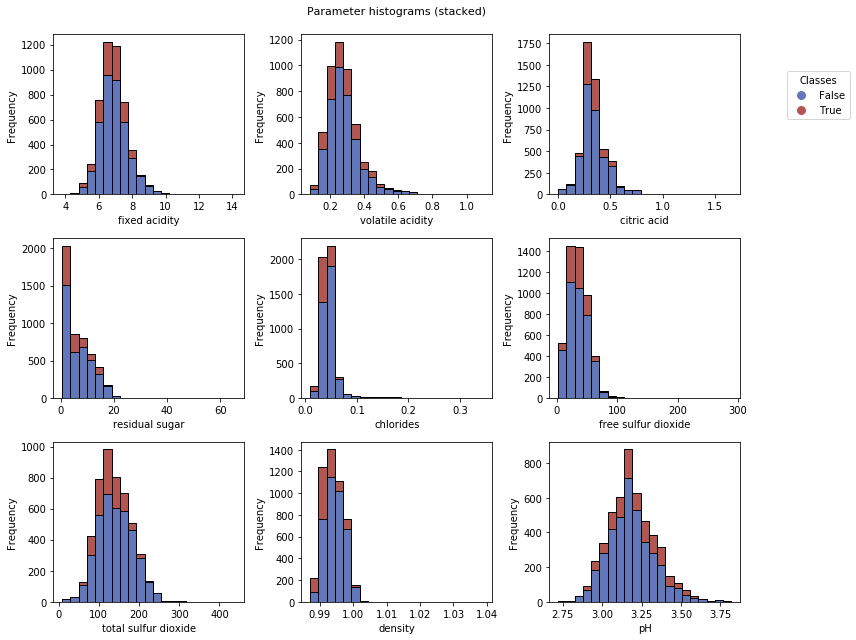


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



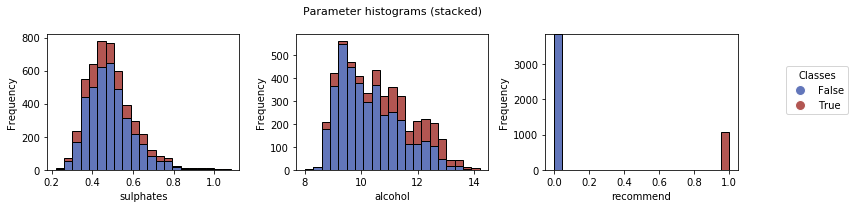

In [91]:
histograms_all(dataset, dataset_name, True, grid=3, bins=21)

### Conclusions in the case of the "winequality.csv" dataset:
* The classes in this dataset are quite mixed, hence we expect it to be **difficult to obtain a good predictive model**.
* The only parameter that displays any indication through visual inspection is **alcohol**, which aparently **tends to be higher for higher quality wines**. And possibly the **density**, which seems to be **slightly lower for those wines**.


## Overlapping variable histograms (winequality.csv)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



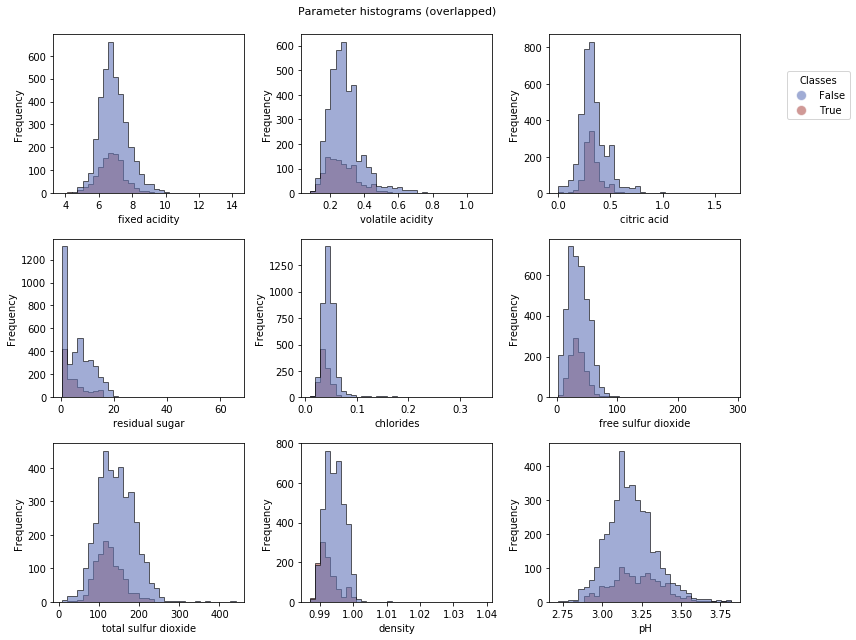


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



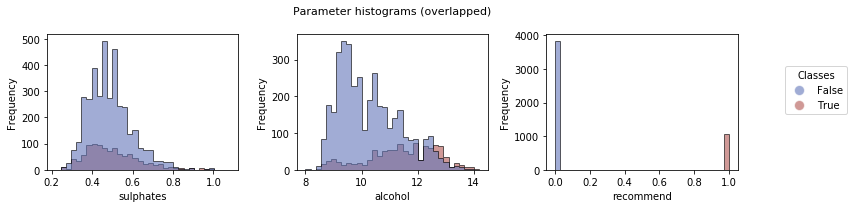

In [28]:
histograms_all(dataset, dataset_name, False, grid=3, bins=34)

### Conclusions in the case of the "winequality.csv" dataset:

* The variable distributions appear to have **irregular peak shapes**.

* These plots confirm the assumption that **alcohol and density are directly and inversely correlated with the quality of the wine**, respectively. **Residual sugar** might as well.

* The class corresponding to the non recommended wine is much more populated so its histogram peaks are higher.

## 2D projections of the variable space (winequality.csv)

Through the projections we can take a closer look at the variables that appear to have a more obvious correlation with wine quality: residual sugar, alcohol, density...


There are 11 variables in this dataset.
Only the crossed projections of 4 parameters at a time will be plotted.


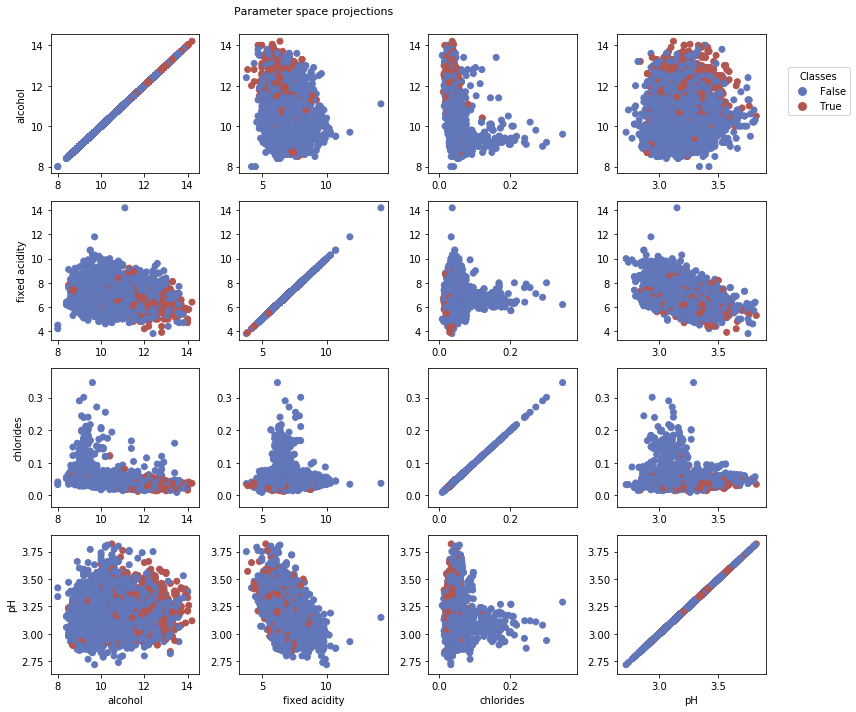


There are 11 variables in this dataset.
Only the crossed projections of 4 parameters at a time will be plotted.


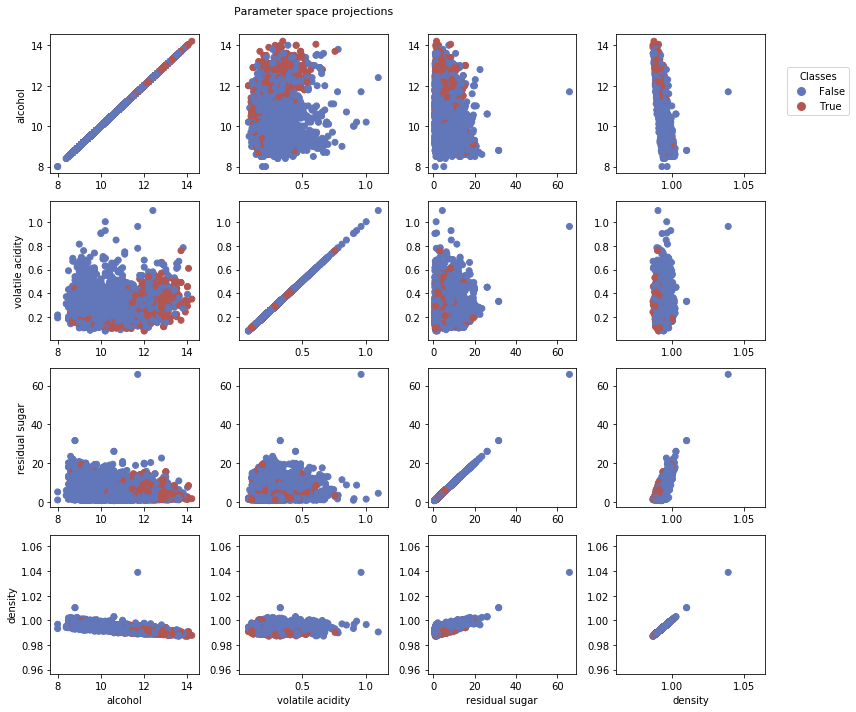

In [29]:
projections_specific(dataset, dataset_name, ["alcohol", "fixed acidity", "chlorides", "pH"])
projections_specific(dataset, dataset_name, ["alcohol", "volatile acidity", "residual sugar", "density"])

### Conclusions in the case of the "winequality.csv" dataset:
* It's reasonable that alcohol will have an inverse correlation with the density, or that the higher the fixed acidity the lower the pH.

* Although the two classes are quite mixed there are large areas in some of the previous projections were one of the two classes is clearly dominant.

# 2. Train the classification model (winequality.csv)
I will also use **support vector classification model** from scikit-learn, starting with the **"linear" kernel** to compare the results with the previous datasets.

### a) Load the dataset and check imbalance
First we check the dataset and determine if we have to **compensate for any imbalance**. The second variable that returns is the maximum ratio between two classes in the dataset. 

In [56]:
dataset, dataset_name = load_file(dataset_files[3])
dataset = dataset.drop(columns=["quality"])

print(weight_advisor(dataset))

(False, 3.620754716981132)


As we have seen before, that is indeed the case, **the dataset is quite unbalanced**.

### b) Separate dataset in a training and validation sets
We will make this separation **randomly** assigning points to each group using "train_test_split" from scikit-learn. Like in the previous example, I will explore the effect of the test fraction split on the average score and standard deviation.

0:00:00.614068 (hh:mm:ss.ss) for 1 iteration/s. 
There are 899 iterations left. 
Estimated total running time: 0:06:08.440800 (hh:mm:ss.ss)
Real total running time: 0:04:22.348585 (hh:mm:ss.ss)


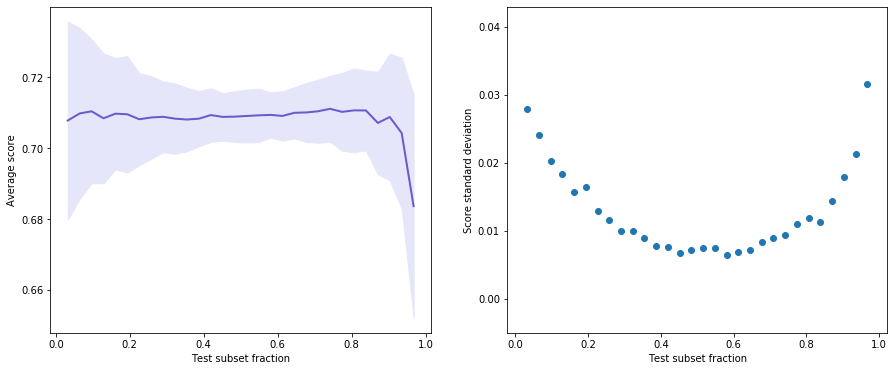


Index of point where score has the smallest standard deviation: 17

Test fraction where score has smallest standard deviation: 0.5806
Average score at test fraction with the smallest standard deviation: 0.7094


In [12]:
score_summary = explore_test_split_ratio(dataset, dataset_name, 30, 30)

### Conclusions in the case of the "winequality.csv" dataset:

* In this case, the average score shows very similar values for almost the whole range.
* The standard deviation also has a very similar shape as in the previous datasets, it increases for extreme values, and it's lower for intermediate values.
* The test fraction around 0,58 is the one that has the lowest standard deviation and it has the same average score than the rest of the values in the plateau. Therefore, I will **assign 58% of points of the sample to the validations** set. 

In [57]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5806, random_state=0)

### c) Check variable scaling and standardize the dataset
As we've previously seen with the **scaling plot()**, the variables of this dataset **need to be reescaled**. 


I've used the **StandardScaler** from the scikit-library, it transforms the data so it has **zero mean and unit variance**. The scaler is fitted to the training data which can then be transformed, but afterwards **the same transformation has to be applied to the validation data**.

In [58]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

### d) Train model
I start with the same simple **linear Suport Vector model** and then adjust it training it with the training data. Since now we have a **binary classification problem** we can let the "decision_function_shape parameter" to use the **"one-vs-rest" approach**. 

In [59]:
classifier = SVC(kernel="linear", decision_function_shape="ovr", class_weight="balanced")
print(classifier)

classifier.fit(X_train_scaled, y_train)
y_predicted = classifier.predict(X_test_scaled)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### e) Evaluate the model
We determine how well the trained model predicts the class of the data that we previously saved for validation. 

1. Using the **accuracy of the SVC model** (in multiclass a subset accuracy).
2. Report with **precision**, **recall**, and **f1-score**.
3. And the **confusion matrix** (compares predicted vs real class of the validation data).
4. For binary classifications a **Receiving Operating Characteristic (ROC) curve** can be used. The **Area Under the Curve (AUC)** gives the probability that the model can discriminate between the two classes.


Score of trained SVC classifier for 'winequality': 0.710618846694796

Classification report for 'winequality': 

               precision    recall  f1-score   support

       False       0.91      0.69      0.79      2217
        True       0.42      0.77      0.54       627

    accuracy                           0.71      2844
   macro avg       0.67      0.73      0.66      2844
weighted avg       0.80      0.71      0.73      2844



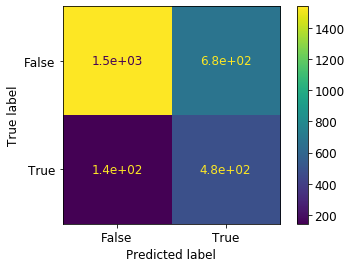

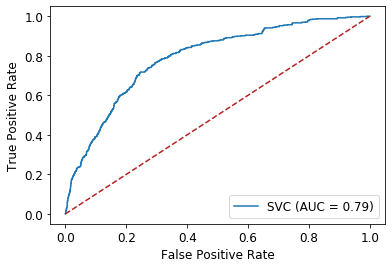

In [60]:
score = classifier.score(X_test_scaled, y_test)
print(f"\nScore of trained SVC classifier for '{dataset_name}': {score}")
plot_confusion_matrix(classifier, X_test_scaled, y_test)
print(f"\nClassification report for '{dataset_name}': \n\n", classification_report(y_test, y_predicted))
figura_roc = plot_roc_curve(classifier, X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], color='firebrick', linestyle='--')

### Conclusions in the case of the "winequality.csv" dataset:
* These metrics show an **modest prediction** using a trained SVC linear model with this dataset (**71,7% accuracy**). 
* The largest proportion of missclassifications were poor wines which were predicted as being recommended. This is possibly also due to the large imbalance of the sample.
* The Area Under the Curve (AUC) of the Receiving Operating Characteristic (ROC) curve is 0,79, which is reasonably good.

#  defaults.csv
This is a dataset corresponding to defaults on credit card payments. There is personal information from the clients and their history of past payments. The goal is to predict which clients will fail to pay and default.

In [61]:
dataset, dataset_name = load_file(dataset_files[4])

# Readjust "pay" values to range from -1 to 9
dataset.iloc[:,6:12] = dataset.iloc[:,6:12].add(1)

# 1. Exploratory analysis of the datasets

## Basic descriptors (defaults.csv)

In [19]:
table_descriptors(dataset)

print("\nIs it necessary to use weights during training to compensate for an unbalance?")
weight_advisor(dataset)


Dataset shape:  (30000, 25)

There are 25 columns: 
['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'defaulted']

This dataset has 2 classes: 
[0, 1]
Each class has [23364, 6636] elements, respectively.
There is a class with 3.5 times more samples than another.

Dataset head:  <bound method NDFrame.head of           id  limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  \
0          1      20000    2          2         1   24      3      3      0   
1          2     120000    2          2         2   26      0      3      1   
2          3      90000    2          2         2   34      1      1      1   
3          4      50000    2          2         1   37      1      1      1   
4          5      50000    1          2         1   57      0      1      0   
..

(False, 3.5207956600361663)

Variables

* **limit_bal**: &nbsp; Amount of the given credit (NT dollar).
* **sex**: &nbsp; 1 = male, &nbsp;  2 = female.
* **education**: &nbsp; 0 = no education, &nbsp; 1 = graduate school, &nbsp; 2 = university, &nbsp; 3 = high school, &nbsp; 4 = others...
* **marriage**: &nbsp; 1 = married, &nbsp; 2 = single, &nbsp; 3 = others.
* **age**: &nbsp; Age in years.

* **pay_0 - pay_6**: &nbsp; History of past payment from last month to 6 months ago: &nbsp;   -1 = pay duly, &nbsp; 1 = one month delay, &nbsp; 2 = two months delay... &nbsp;  8 = eight months delay, &nbsp; 9 = nine months delay and above.  
  
* **bill_amt1 - bill_amt6**: &nbsp; Amount of bill statement from last month to 6 months ago (NT dollar).

* **pay_amt1 - pay_amt6**: &nbsp; Amount of previous payment from last month to 6 months ago (NT dollar).

* **defaulted**:  &nbsp; no = 0, &nbsp; yes = 1.

### Conclusions in the case of the "defaults.csv" dataset:
* This is a dataset with a good volume of data.
* There are only 2 classes, defaulted (1) and not defaulted (0), so in principle we could use a **binary classifier**.
* This sample is also **quite unbalanced**, there are 3,5 times more people who didn't have any problem than people who defaulted. Therefore, we will use **weights** during the training of the model to compensate.

## Variable scaling (defaults.csv)

                min        max   interval
id              1.0    30000.0    29999.0
limit_bal   10000.0  1000000.0   990000.0
sex             1.0        2.0        1.0
education       0.0        6.0        6.0
marriage        0.0        3.0        3.0
age            21.0       79.0       58.0
pay_0          -1.0        9.0       10.0
pay_2          -1.0        9.0       10.0
pay_3          -1.0        9.0       10.0
pay_4          -1.0        9.0       10.0
pay_5          -1.0        9.0       10.0
pay_6          -1.0        9.0       10.0
bill_amt1 -165580.0   964511.0  1130091.0
bill_amt2  -69777.0   983931.0  1053708.0
bill_amt3 -157264.0  1664089.0  1821353.0
bill_amt4 -170000.0   891586.0  1061586.0
bill_amt5  -81334.0   927171.0  1008505.0
bill_amt6 -339603.0   961664.0  1301267.0
pay_amt1        0.0   873552.0   873552.0
pay_amt2        0.0  1684259.0  1684259.0
pay_amt3        0.0   896040.0   896040.0
pay_amt4        0.0   621000.0   621000.0
pay_amt5        0.0   426529.0   4

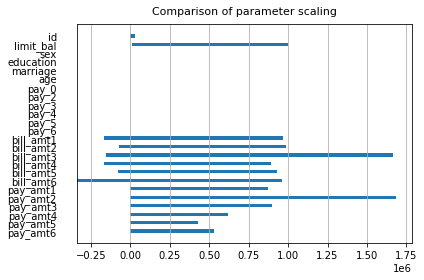

In [100]:
scaling_plot(dataset.iloc[:,:-1], dataset_name)

### Conclusions in the case of the "defaults.csv" dataset:
* The **differences in scaling in this dataset are huge**, there are 6 orders of magnitude between some of the variables. Hence, we must surely reescale the data to ensure a good fit of the model.

## Stacked variable histograms (defaults.csv)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



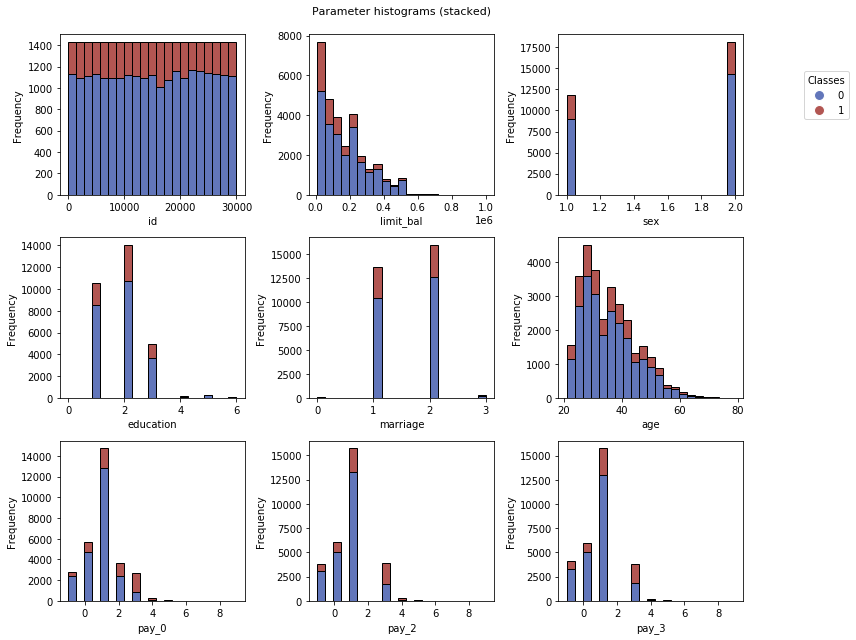


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



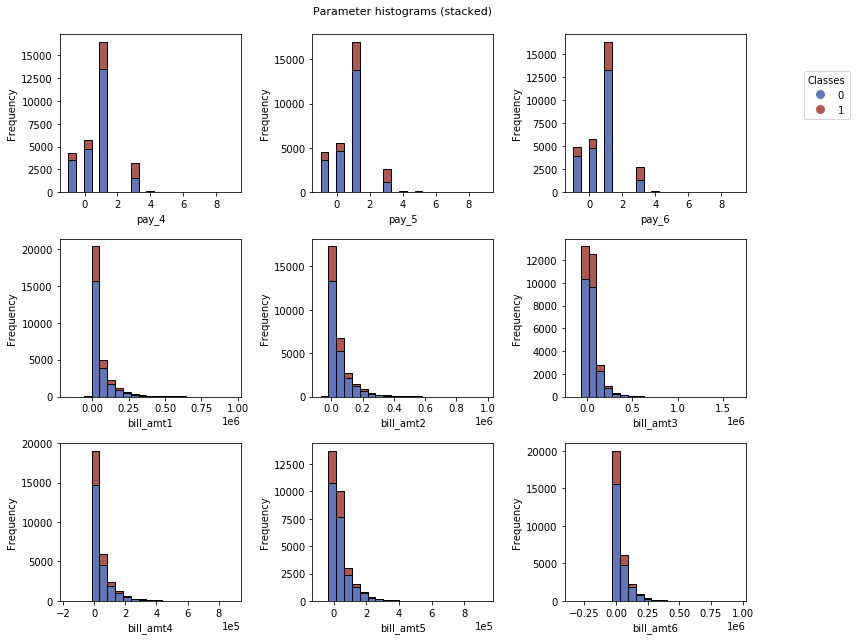


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



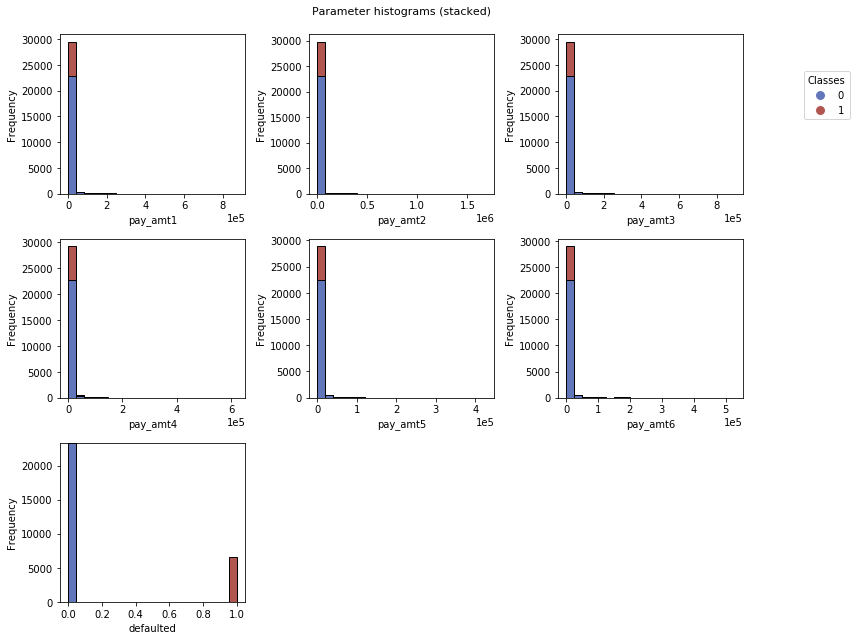

In [50]:
histograms_all(dataset, dataset_name, True, grid=3, bins=21)

### Conclusions in the case of the "defaults.csv" dataset:
* The classes in this dataset are quite mixed, hence we expect it to be **difficult to obtain a good predictive model**.
* The only **distinc feature** between classes that can be easily determined by visual inspection of these graphs is that the **delay in paying previous bills** (pay0-pay6) is **shifted to longer times** for clients who **defaulted**.

## Overlapping variable histograms (defaults.csv)


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



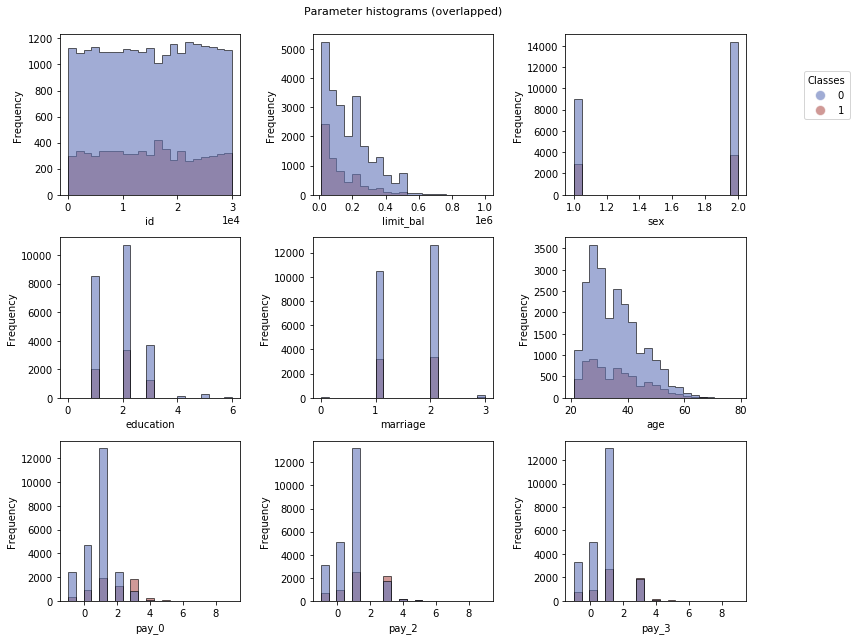


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



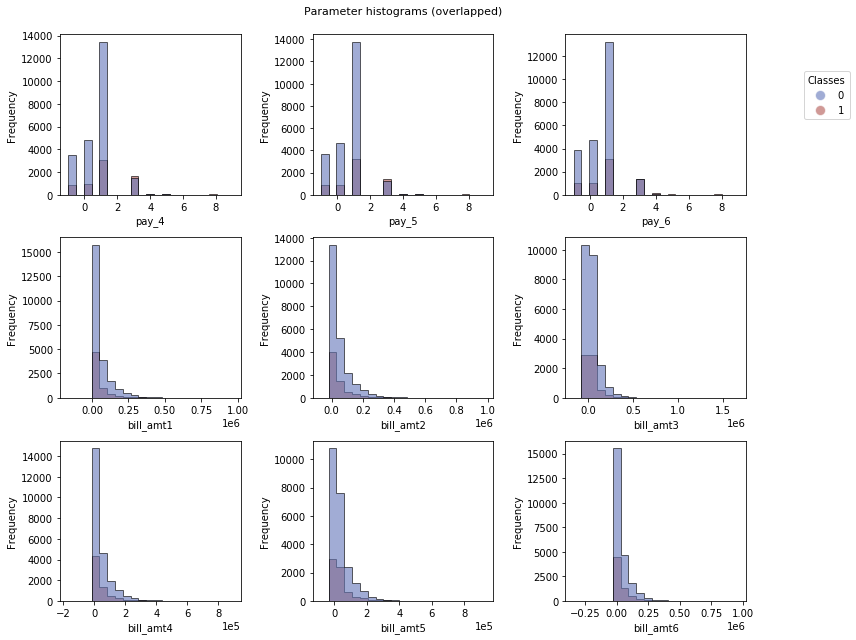


You chose a 3x3 grid, the histograms will be calculated maximum 9 at a time.



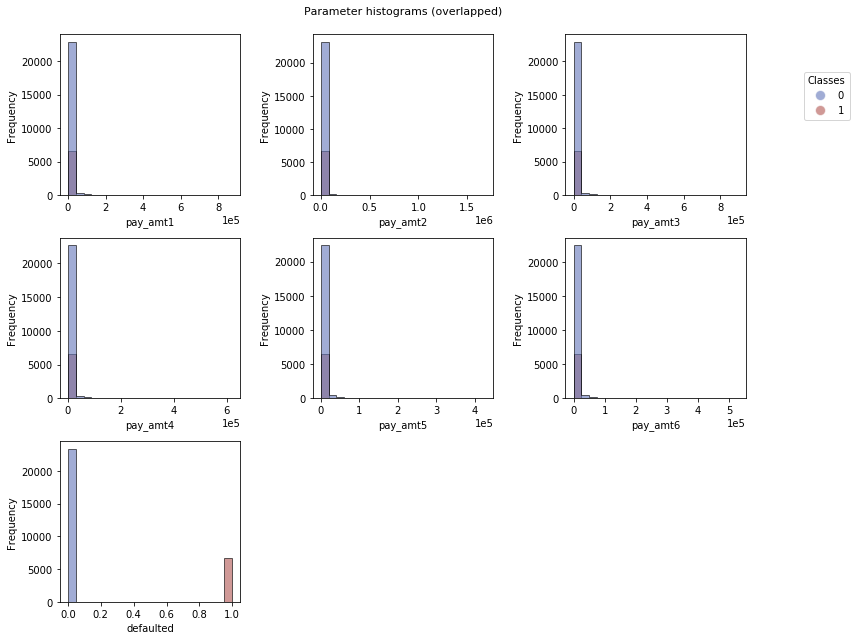

In [5]:
histograms_all(dataset, dataset_name, False, grid=3, bins=21)

### Conclusions in the case of the "defaults.csv" dataset:

* Like mentioned earlier, there are almost **no distinct differences** in the features **between class distributions**.
* The only **distinct feature** between classes that can be easily determined by visual inspection is that the **delay in paying previous bills** (pay0-pay6) is **shifted to longer times** for clients who **defaulted**.

* The class corresponding to clients that didn't default is much more populated so its histogram peaks are higher.

## 2D projections of the variable space (defaults.csv)


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


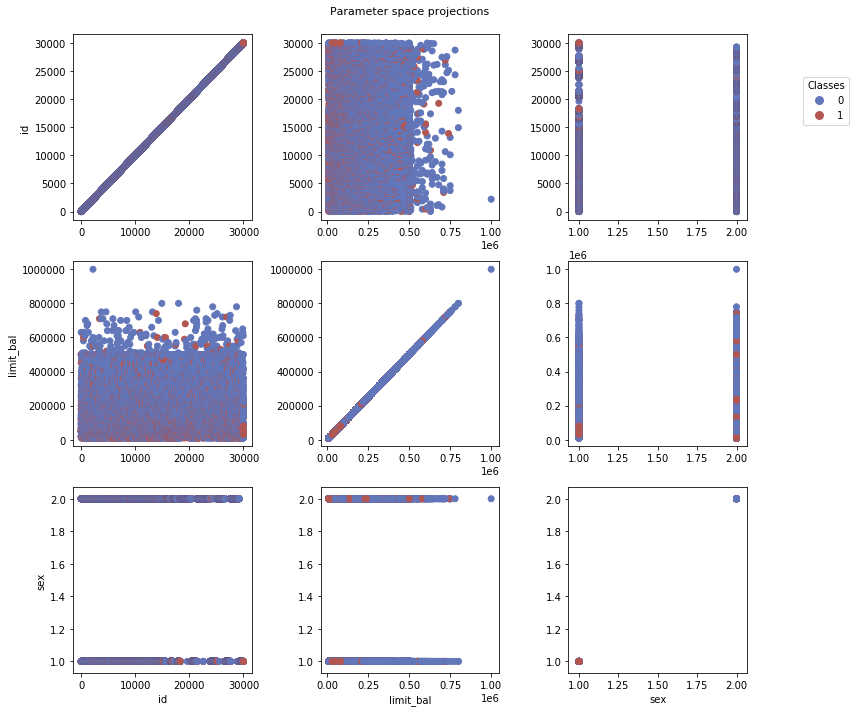


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


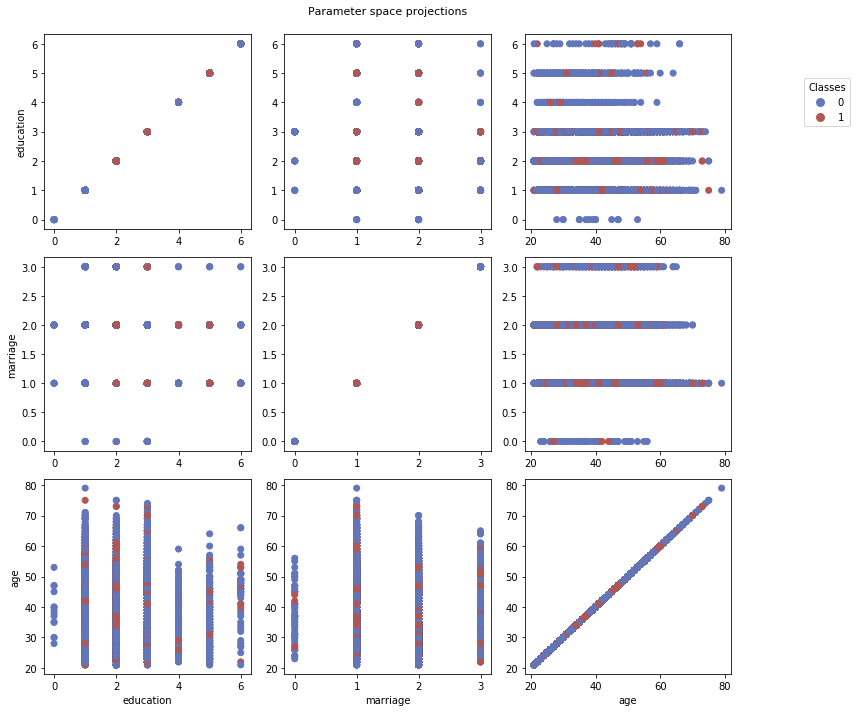


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


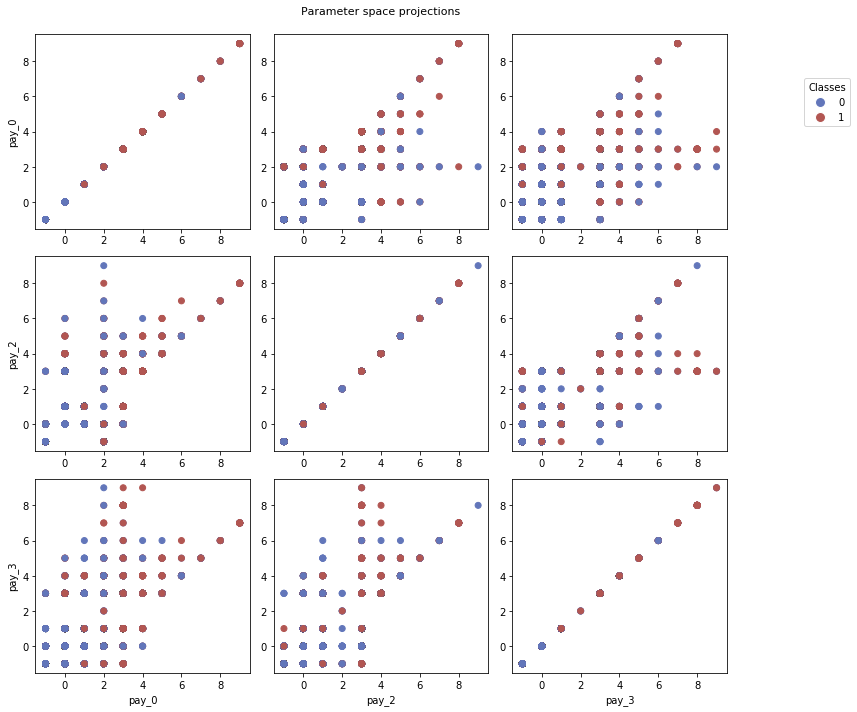


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


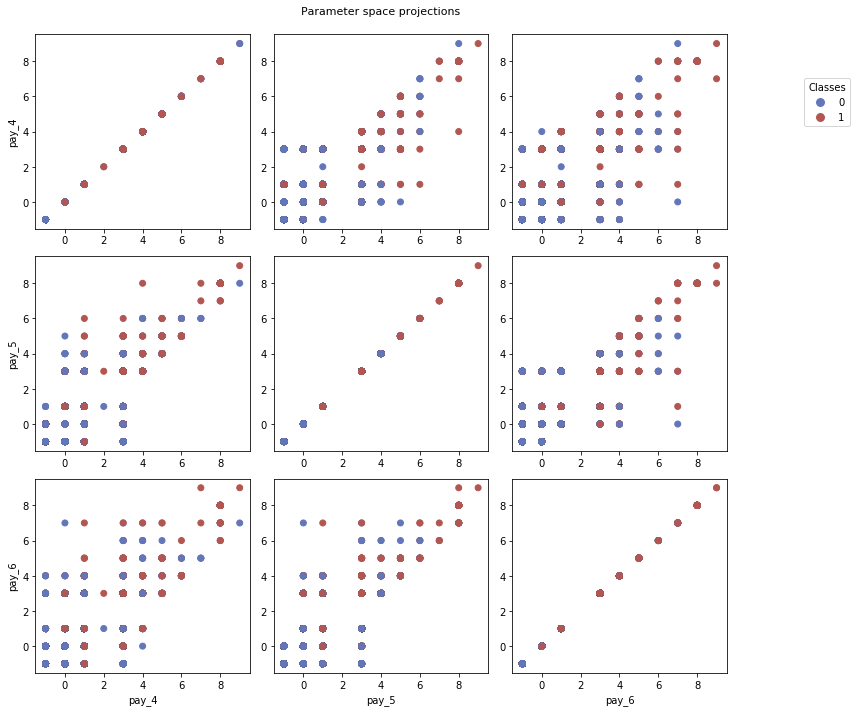


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


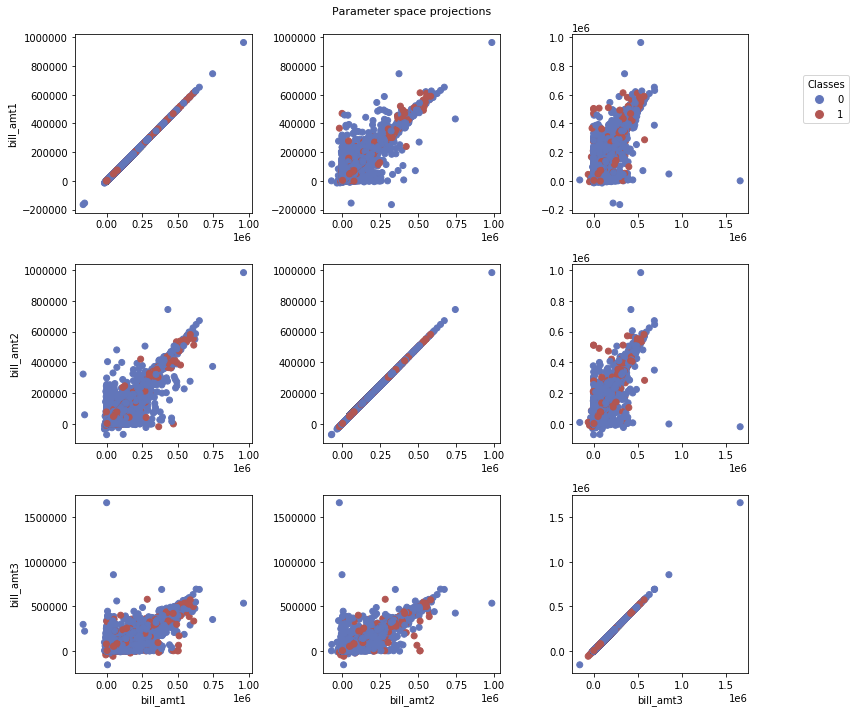


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


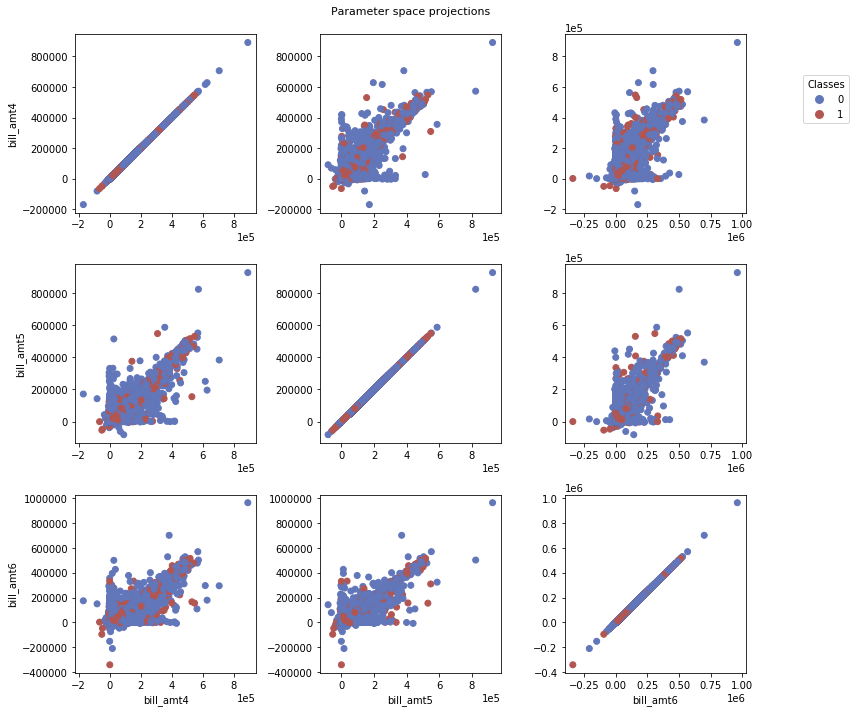


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


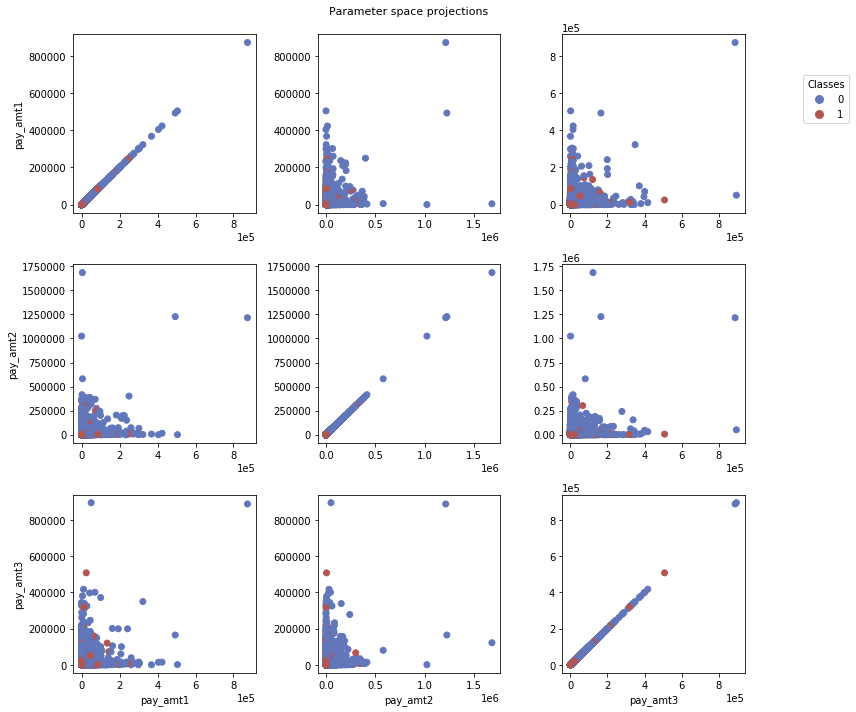


There are 24 variables in this dataset.
Only the crossed projections of 3 parameters at a time will be plotted.


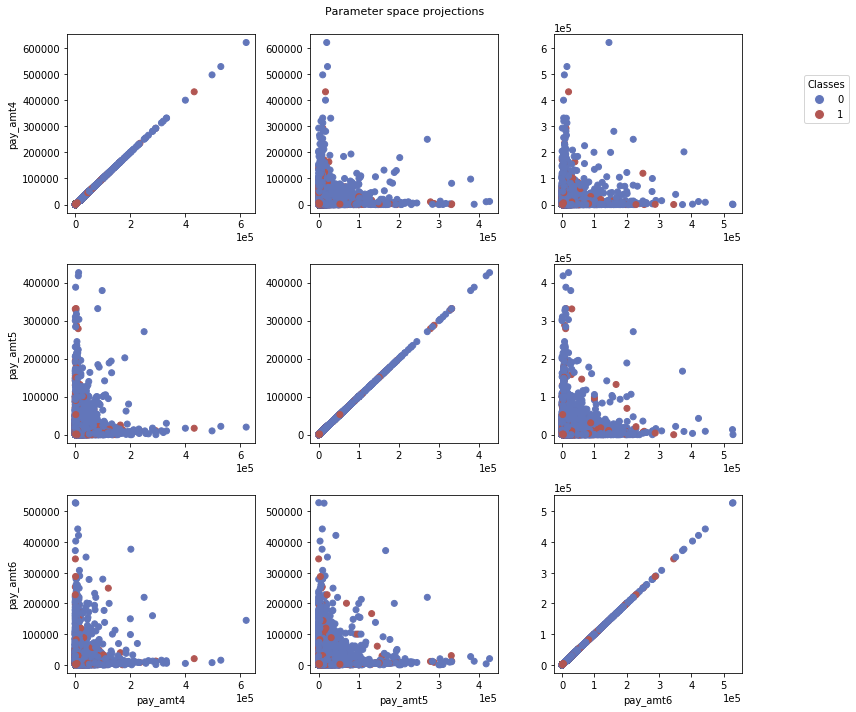

In [52]:
projections_all(dataset, dataset_name, grid=3)

### Conclusions in the case of the "defaults.csv" dataset:
* Clients with **lower credit limits** ("limit_bal") are more likely to **default**. Possibly because the bank already set lower limits to clients which were considered as less reliable.
* **Bill amounts** from the last six months ("bill_amt") **show certain correlation** among them. Probably because clients have a tendency to charge their credit card with a **similar volume of expenses every month**. 
* The projections from discrete variables have a superposition of data points in the same coordinates, so no conclusions can be drawn from such plots.

# 2. Train the classification model (defaults.csv)
I will also use **support vector classification model** from scikit-learn, starting with the **"linear" kernel** to compare the results with the previous datasets.

### a) Load the dataset and check imbalance
First we check the dataset and determine if we have to **compensate for any imbalance**. The second variable that returns is the maximum ratio between two classes in the dataset. 

In [62]:
dataset, dataset_name = load_file(dataset_files[4])

print(weight_advisor(dataset))

(False, 3.5207956600361663)


As we have seen before, that is indeed the case, **the dataset is quite unbalanced**.

### b) Separate dataset in a training and validation sets
We will make this separation **randomly** assigning points to each group using "train_test_split" from scikit-learn. 

0:00:48.206391 (hh:mm:ss.ss) for 1 iteration/s. 
There are 49 iterations left. 
Estimated total running time: 0:26:46.879700 (hh:mm:ss.ss)
Real total running time: 0:19:43.539106 (hh:mm:ss.ss)


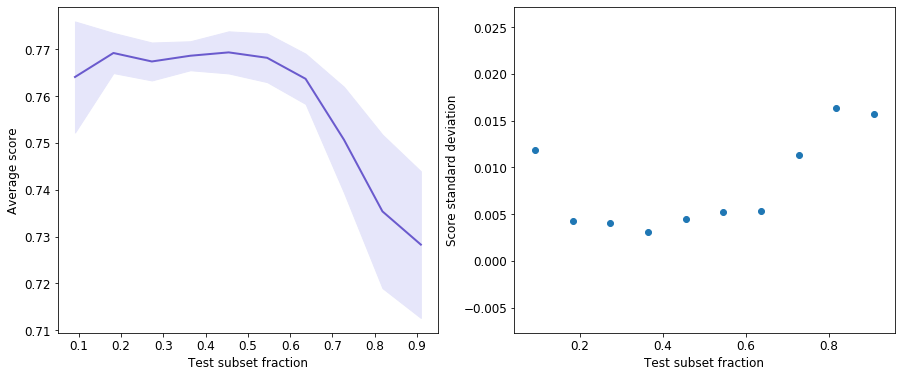


Index of point where score has the smallest standard deviation: 3

Test fraction where score has smallest standard deviation: 0.3636
Average score at test fraction with the smallest standard deviation: 0.7686


In [21]:
score_summary = explore_test_split_ratio(dataset, dataset_name, 10, 5)

* I will use a **test data fraction of 36,36%**, because it corresponds to the lowest standard deviation and the average score is one of the highest. 

In [63]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3636, random_state=0)

### c) Check variable scaling and standardize the dataset
As we've previously seen with the **scaling plot()**, the variables of this dataset **need to be reescaled**. 


I've used the **StandardScaler** from the scikit-library, it transforms the data so it has **zero mean and unit variance**. The scaler is fitted to the training data which can then be transformed, but afterwards **the same transformation has to be applied to the validation data**.

In [64]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

### d) Train model
I start with the same simple **linear Suport Vector model** and then adjust it training it with the training data. Since now we have a **binary classification problem** we can let the "decision_function_shape parameter" to use the **"one-vs-rest" approach**. 

In [65]:
classifier = SVC(kernel="linear", decision_function_shape="ovr", class_weight="balanced")
print(classifier)

classifier.fit(X_train_scaled, y_train)
y_predicted = classifier.predict(X_test_scaled)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### e) Evaluate the model
We determine how well the trained model predicts the class of the data that we previously saved for validation. 

1. Using the **accuracy of the SVC model** (in multiclass a subset accuracy).
2. Report with **precision**, **recall**, and **f1-score**.
3. And the **confusion matrix** (compares predicted vs real class of the validation data).
4. For binary classifications a **Receiving Operating Characteristic (ROC) curve** can be used. The **Area Under the Curve (AUC)** gives the probability that the model can discriminate between the two classes.


Score of trained SVC classifier for 'defaults': 0.7668683535020169

Classification report for 'defaults': 

               precision    recall  f1-score   support

           0       0.87      0.83      0.85      8568
           1       0.46      0.54      0.50      2340

    accuracy                           0.77     10908
   macro avg       0.67      0.68      0.67     10908
weighted avg       0.78      0.77      0.77     10908



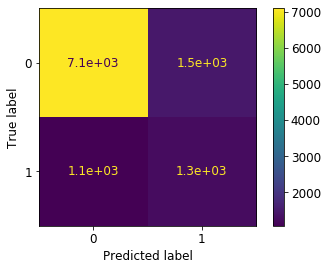

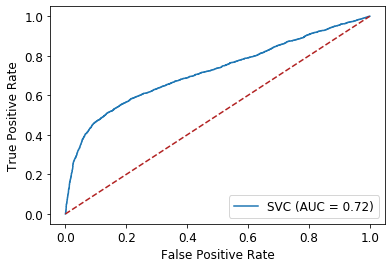

In [66]:
score = classifier.score(X_test_scaled, y_test)
print(f"\nScore of trained SVC classifier for '{dataset_name}': {score}")
plot_confusion_matrix(classifier, X_test_scaled, y_test)
print(f"\nClassification report for '{dataset_name}': \n\n", classification_report(y_test, y_predicted))
figura_roc = plot_roc_curve(classifier, X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], color='firebrick', linestyle='--')

### Conclusions in the case of the "defaults.csv" dataset:
* These metrics show an **modest prediction** using a trained SVC linear model with this dataset (**76,2% accuracy**). 
* There are a large number of missclassifications both for clients who defaulted and clients who didn't. 
* The relatively high accuracy despite the high number of missclassifications is possibly due to the large imbalance of the sample.
* The Area Under the Curve (AUC) of the Receiving Operating Characteristic (ROC) curve is 0,72.